# Import Libraries

In [4]:
from datasets import load_dataset
import pandas as pd
import logging
import time
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains import LLMChain
from langchain_groq import ChatGroq
import os
from langchain_cohere import ChatCohere

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from IPython.display import display, HTML

d:\Teias\Thesis\self-explaination-thesis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Teias\Thesis\self-explaination-thesis\.venv\lib\site-packages\pydantic\_internal\_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has been renamed to 'populate_by_name'
* 'smart_union' has been removed
  warnings.warn(message, UserWarning)


# Code Template

In [30]:
os.environ['COHERE_API_KEY'] = '47amNsxWIPexaTSxCmteAskkxXJ9XVfB2nClzP0j'

In [10]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

# Function to check the API with custom parameters: model_name and temperature
def check_api_with_parameters(model_name, temperature):
    # Define the language model with the given model_name and temperature
    llm = ChatCohere(
        model=model_name,              # Your chosen model
        temperature=temperature,       # Set temperature to control randomness
        max_tokens=None,               # Unlimited tokens, depending on model capability
        timeout=None,                  # Timeout setting, if any
        max_retries=2                  # Retry in case of failed requests
    )

    return llm

# Function to predict the correct answer
def predict_answer(passage, question, options, llm):
    logging.info(f"Starting prediction for passage: {passage[:50]}... and question: {question}")
    try:
        # Define the messages for Cohere
        messages = [
            {
                "role": "system",
                "content": f"You are an expert assistant. Read the passage below and predict the correct answer based on the question.\n\nPassage:\n\n{passage}\n\nQuestion:\n{question}\n\nBased on the passage, predict the correct answer by selecting the corresponding number. (Only provide the correct number (1, 2, 3, or 4) as the answer.)"
            },
            {
                "role": "user",
                "content": f"Options:\n1. {options[0]}\n2. {options[1]}\n3. {options[2]}\n4. {options[3]}"
            }
        ]
        
        # Use invoke to get the result
        result = llm.invoke(messages)

        # Extract the predicted answer
        answer = result.content.strip()
        logging.info(f"Predicted answer: {answer}")
        return answer
    except Exception as e:
        logging.error(f"Error in predict_answer: {e}")
        return "error"

# Retry function
def make_request_with_retry(func, *args, retries=3, delay=10):
    for attempt in range(retries):
        try:
            return func(*args)
        except ConnectionError as e:
            logging.warning(f"Attempt {attempt + 1} failed: {e}. Retrying in {delay} seconds...")
            time.sleep(delay)
    logging.error("Max retries exceeded")
    raise ConnectionError("Max retries exceeded")

# Function to apply the prediction logic to the dataset
def apply_prediction(df, model_name, temperature):
    # Check API with custom model_name and temperature
    llm = check_api_with_parameters(model_name, temperature)

    results = []

    for index, row in df.iterrows():
        passage = row['flores_passage']
        question = row['question']
        options = [row['mc_answer1'], row['mc_answer2'], row['mc_answer3'], row['mc_answer4']]
        original_answer = row['correct_answer_num']

        logging.info(f"Processing row {index+1}/{len(df)}: {passage[:50]}...")

        # Predict answer with retries
        predicted_answer = make_request_with_retry(predict_answer, passage, question, options, llm)
        time.sleep(5)
        # Append the result
        results.append({
            "Passage": passage,
            "Question": question,
            "Original Answer": original_answer,
            "Predicted Answer": predicted_answer,
            "Option 1": options[0],
            "Option 2": options[1],
            "Option 3": options[2],
            "Option 4": options[3]
        })

        logging.info(f"Row {index+1} processed successfully.")

    # Create a new DataFrame with the results
    result_df = pd.DataFrame(results)
    logging.info("Finished processing all rows.")

    # Save the DataFrame to CSV
    result_df.to_csv("predicted_answers.csv", index=False)
    logging.info("Results saved to predicted_answers.csv")

    return result_df

# Predict correct answer - Cohere

In [39]:
df = pd.read_csv('pes_arab_dataset.csv')

# Apply the prediction
apply_prediction(df, model_name="command-r-plus", temperature=0.3)


2024-10-25 20:25:57,300 - Processing row 1/900: بسیاری، ریتم‌های فیزیولوژی و رفتار را غالباً به صو...
2024-10-25 20:25:57,300 - Starting prediction for passage: بسیاری، ریتم‌های فیزیولوژی و رفتار را غالباً به صو... and question: کدام یک از موارد زیر علیرغم وجود نشانه‌های خارجی ادامه پیدا خواهد کرد؟
2024-10-25 20:25:58,061 - HTTP Request: POST https://api.cohere.com/v1/chat "HTTP/1.1 200 OK"
2024-10-25 20:25:58,067 - Predicted answer: 3
2024-10-25 20:26:03,073 - Row 1 processed successfully.
2024-10-25 20:26:03,073 - Processing row 2/900: جمعیت عبارت است از مجموعه‌ای از موجودات زنده یک گو...
2024-10-25 20:26:03,073 - Starting prediction for passage: جمعیت عبارت است از مجموعه‌ای از موجودات زنده یک گو... and question: کدام واژه افرادی را توصیف می‌کند که چندین نوع از خصوصیت فنوتیپی خاصی را نشان می‌دهند؟
2024-10-25 20:26:04,064 - HTTP Request: POST https://api.cohere.com/v1/chat "HTTP/1.1 200 OK"
2024-10-25 20:26:04,072 - Predicted answer: 4
2024-10-25 20:26:09,078 - Row 2 processed success

,Passage,Question,Original Answer,Predicted Answer,Option 1,Option 2,Option 3,Option 4
0,بسیاری، ریتم‌های فیزیولوژی و رفتار را غالباً ب...,کدام یک از موارد زیر علیرغم وجود نشانه‌های خار...,3,3,چرخه درون‌زا,ریتم‌های دوره‌ای,ساعت‌های بیولوژیک,ریتم‌های مشاهده‌شده
1,جمعیت عبارت است از مجموعه‌ای از موجودات زنده ی...,کدام واژه افرادی را توصیف می‌کند که چندین نوع ...,4,4,تک‌شکل,ارگانیسم‌ها,گونه‌ها,چند شکلی
2,جمعیت عبارت است از مجموعه‌ای از موجودات زنده ی...,کدام مورد اصطلاح صحیح برای ارگانیسم‌هایی است ک...,2,2,تک‌شکل,جمعیت,گونه‌ها,چند شکلی
3,جهانگردی طبیعت‌دوست به جذب افراد علاقه‌مند به ...,کدام یک از موارد زیر مثالی از گردشگری طبیعت‌دو...,3,3,پیاده‌روی تا آبشار,عکسبرداری از گل‌های وحشی,بازدید از موزه‌های علوم,ماهیگیری با حشره مصنوعی
4,هر روز صبح، مردم شهرهای کوچک شهرستان را با اتو...,با توجه به متن، کدام یک از موارد زیر مبنای سیس...,2,2.,مقاصد کاری,اتومبیل‌های شخصی,بیوسفر پایدار,تکامل انسان
...,...,...,...,...,...,...,...,...
895,قالب‌های بسیار مختلفی از فیلم وجود دارد که طی ...,کدام‌یک از قالب‌های فیلم وضوح تصویری ارائه می‌...,1,error,فیلم 35 میلی‌متری,فیلم با قالب متوسط,فیلم 56 در 56 میلی‌متر,فیلم 6 در 6 سانتی‌متر
896,ساده ترین راه برای شروع کار در زمینه سفرنامه ن...,مطابق با این متن، کدام‌یک از این موارد آخرین م...,3,error,تمرین فرمت‌بندی وب,نوشتن مقالات متعدد برای یک وبلاگ مسافرتی سرشناس,ساخت وب‌سایت خودتان,بهبود بخشیدن مهارت‌های ویرایشتان
897,ساده ترین راه برای شروع کار در زمینه سفرنامه ن...,هنگام شروع یک کار سفرنامه‌نویسی، کدام‌یک از فع...,1,error,وبلاگ‌نویسی,فرمت‌بندی وب,ویرایش,ایجاد وب‌سایت
898,در خانه بدلیل قرارگیری مداوم در معرض میکروب‌ها...,مشکلات گوارشی معمولاً در چه نوع آب‌وهوایی یافت...,3,error,آب‌وهوای سرد,آب‌وهوای قطبی,آب‌وهوای گرم,آب‌وهوای خشک


## Clean Result

In [3]:
res = pd.read_csv('predicted_answers.csv')

In [41]:
res.head()

,Passage,Question,Original Answer,Predicted Answer,Option 1,Option 2,Option 3,Option 4
0,بسیاری، ریتم‌های فیزیولوژی و رفتار را غالباً ب...,کدام یک از موارد زیر علیرغم وجود نشانه‌های خار...,3,3,چرخه درون‌زا,ریتم‌های دوره‌ای,ساعت‌های بیولوژیک,ریتم‌های مشاهده‌شده
1,جمعیت عبارت است از مجموعه‌ای از موجودات زنده ی...,کدام واژه افرادی را توصیف می‌کند که چندین نوع ...,4,4,تک‌شکل,ارگانیسم‌ها,گونه‌ها,چند شکلی
2,جمعیت عبارت است از مجموعه‌ای از موجودات زنده ی...,کدام مورد اصطلاح صحیح برای ارگانیسم‌هایی است ک...,2,2,تک‌شکل,جمعیت,گونه‌ها,چند شکلی
3,جهانگردی طبیعت‌دوست به جذب افراد علاقه‌مند به ...,کدام یک از موارد زیر مثالی از گردشگری طبیعت‌دو...,3,3,پیاده‌روی تا آبشار,عکسبرداری از گل‌های وحشی,بازدید از موزه‌های علوم,ماهیگیری با حشره مصنوعی
4,هر روز صبح، مردم شهرهای کوچک شهرستان را با اتو...,با توجه به متن، کدام یک از موارد زیر مبنای سیس...,2,2.,مقاصد کاری,اتومبیل‌های شخصی,بیوسفر پایدار,تکامل انسان


In [42]:
res['Predicted Answer']

Predicted Answer
3                    153
2                    146
4                    136
error                118
1                    104
1.                    72
2.                    69
3.                    61
4.                    36
1. مذاکره‌کنندگان      1
45                     1
4. بیش از 1,000        1
2. 29 درصد             1
2. Puerto Jiménez      1
Name: count, dtype: int64

In [4]:
res[res['Predicted Answer'] == '2. Puerto Jiménez']

,Passage,Question,Original Answer,Predicted Answer,Option 1,Option 2,Option 3,Option 4
719,مجوزها را باید از قبل رزرو کرد. برای اقامت شبا...,مطابق با متن، اگر بخواهید بجای کارت اعتباری از...,2,2. Puerto Jiménez,سیرنا,Puerto Jiménez,CafeNet El Sol,لا لئونا


In [5]:
res.loc[res['Predicted Answer'] == '2. Puerto Jiménez', 'Predicted Answer'] = 2

In [6]:
res[res['Predicted Answer'] == '45']

,Passage,Question,Original Answer,Predicted Answer,Option 1,Option 2,Option 3,Option 4
517,پس از مسابقه چهارشنبه، کارپاندو در دو مسابقه ا...,چند رقیب اسکی مارپیچ بزرگ را به پایان نرساندند؟,3,45,36,117,4,45


In [7]:
res.loc[res['Predicted Answer'] == '45'] = 4

In [8]:
res['Predicted Answer'] = res['Predicted Answer'].replace({'1.': '1', '2.': '2', '3.': '3', '4.': '4'})

In [9]:
res[res['Predicted Answer'] == 2]

,Passage,Question,Original Answer,Predicted Answer,Option 1,Option 2,Option 3,Option 4
719,مجوزها را باید از قبل رزرو کرد. برای اقامت شبا...,مطابق با متن، اگر بخواهید بجای کارت اعتباری از...,2,2,سیرنا,Puerto Jiménez,CafeNet El Sol,لا لئونا


In [10]:
res.loc[res['Predicted Answer'] == 2] = '2'

C:\Users\Active\AppData\Local\Temp\ipykernel_27208\1154442457.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  res.loc[res['Predicted Answer'] == 2] = '2'


In [11]:
# Strip leading and trailing spaces and periods
res['Predicted Answer'] = res['Predicted Answer'].str.strip()

res['Predicted Answer'].value_counts()


Predicted Answer
2                    216
3                    214
1                    176
4                    172
error                118
1. مذاکره‌کنندگان      1
4. بیش از 1,000        1
2. 29 درصد             1
Name: count, dtype: int64

In [12]:
# Find rows where 'Predicted Answer' is not in ['1', '2', '3', '4', 'error']
invalid_rows = res[~res['Predicted Answer'].isin(['1', '2', '3', '4', 'error'])]

invalid_rows

,Passage,Question,Original Answer,Predicted Answer,Option 1,Option 2,Option 3,Option 4
356,وقتی درگیری متوقف شد و زخمی‌ها به بیمارستان ان...,با توجه به متن، چه کسانی با زندانیانی که پس از...,4,1. مذاکره‌کنندگان,مذاکره‌کنندگان,خدمه گروه آتش‌نشانی,افسران,کارکنان بیمارستان
517,4,4,4,NaN,4,4,4,4
538,در 1956 اسلانیا به سوئد رفت، سه سال بعد در آنج...,اسلانیا چند تمبر برای کشورهای مختلف تولید کرد؟,4,"4. بیش از 1,000","بیش از 2,000",1000,"تقریباً 2,000","بیش از 1,000"
603,"از بین 1,400 نفری که قبل از انتخابات فدرال 201...",چند درصد از افراد نظرسنجی‌شده از جمهوری شدن فو...,2,2. 29 درصد,31 درصد,29 درصد,8 درصد,34 درصد


In [13]:
res['Predicted Answer'] = res['Predicted Answer'].replace({
    '1. مذاکره‌کنندگان': '1',
    '4. بیش از 1,000': '4',
    '2. 29 درصد': '2'
})

In [14]:
res['Predicted Answer'].value_counts()

Predicted Answer
2        217
3        214
1        177
4        173
error    118
Name: count, dtype: int64

In [15]:
# Drop rows where all options are the same (e.g., 4 4 4 4)
df_cleaned = res[~((res['Option 1'] == res['Option 2']) & (res['Option 1'] == res['Option 3']) & (res['Option 1'] == res['Option 4']))]

df_cleaned

,Passage,Question,Original Answer,Predicted Answer,Option 1,Option 2,Option 3,Option 4
0,بسیاری، ریتم‌های فیزیولوژی و رفتار را غالباً ب...,کدام یک از موارد زیر علیرغم وجود نشانه‌های خار...,3,3,چرخه درون‌زا,ریتم‌های دوره‌ای,ساعت‌های بیولوژیک,ریتم‌های مشاهده‌شده
1,جمعیت عبارت است از مجموعه‌ای از موجودات زنده ی...,کدام واژه افرادی را توصیف می‌کند که چندین نوع ...,4,4,تک‌شکل,ارگانیسم‌ها,گونه‌ها,چند شکلی
2,جمعیت عبارت است از مجموعه‌ای از موجودات زنده ی...,کدام مورد اصطلاح صحیح برای ارگانیسم‌هایی است ک...,2,2,تک‌شکل,جمعیت,گونه‌ها,چند شکلی
3,جهانگردی طبیعت‌دوست به جذب افراد علاقه‌مند به ...,کدام یک از موارد زیر مثالی از گردشگری طبیعت‌دو...,3,3,پیاده‌روی تا آبشار,عکسبرداری از گل‌های وحشی,بازدید از موزه‌های علوم,ماهیگیری با حشره مصنوعی
4,هر روز صبح، مردم شهرهای کوچک شهرستان را با اتو...,با توجه به متن، کدام یک از موارد زیر مبنای سیس...,2,2,مقاصد کاری,اتومبیل‌های شخصی,بیوسفر پایدار,تکامل انسان
...,...,...,...,...,...,...,...,...
895,قالب‌های بسیار مختلفی از فیلم وجود دارد که طی ...,کدام‌یک از قالب‌های فیلم وضوح تصویری ارائه می‌...,1,error,فیلم 35 میلی‌متری,فیلم با قالب متوسط,فیلم 56 در 56 میلی‌متر,فیلم 6 در 6 سانتی‌متر
896,ساده ترین راه برای شروع کار در زمینه سفرنامه ن...,مطابق با این متن، کدام‌یک از این موارد آخرین م...,3,error,تمرین فرمت‌بندی وب,نوشتن مقالات متعدد برای یک وبلاگ مسافرتی سرشناس,ساخت وب‌سایت خودتان,بهبود بخشیدن مهارت‌های ویرایشتان
897,ساده ترین راه برای شروع کار در زمینه سفرنامه ن...,هنگام شروع یک کار سفرنامه‌نویسی، کدام‌یک از فع...,1,error,وبلاگ‌نویسی,فرمت‌بندی وب,ویرایش,ایجاد وب‌سایت
898,در خانه بدلیل قرارگیری مداوم در معرض میکروب‌ها...,مشکلات گوارشی معمولاً در چه نوع آب‌وهوایی یافت...,3,error,آب‌وهوای سرد,آب‌وهوای قطبی,آب‌وهوای گرم,آب‌وهوای خشک


In [16]:
# Remove rows where the 'Predicted Answer' column contains 'error'
df_no_errors = df_cleaned[df_cleaned['Predicted Answer'] != 'error']

df_no_errors

,Passage,Question,Original Answer,Predicted Answer,Option 1,Option 2,Option 3,Option 4
0,بسیاری، ریتم‌های فیزیولوژی و رفتار را غالباً ب...,کدام یک از موارد زیر علیرغم وجود نشانه‌های خار...,3,3,چرخه درون‌زا,ریتم‌های دوره‌ای,ساعت‌های بیولوژیک,ریتم‌های مشاهده‌شده
1,جمعیت عبارت است از مجموعه‌ای از موجودات زنده ی...,کدام واژه افرادی را توصیف می‌کند که چندین نوع ...,4,4,تک‌شکل,ارگانیسم‌ها,گونه‌ها,چند شکلی
2,جمعیت عبارت است از مجموعه‌ای از موجودات زنده ی...,کدام مورد اصطلاح صحیح برای ارگانیسم‌هایی است ک...,2,2,تک‌شکل,جمعیت,گونه‌ها,چند شکلی
3,جهانگردی طبیعت‌دوست به جذب افراد علاقه‌مند به ...,کدام یک از موارد زیر مثالی از گردشگری طبیعت‌دو...,3,3,پیاده‌روی تا آبشار,عکسبرداری از گل‌های وحشی,بازدید از موزه‌های علوم,ماهیگیری با حشره مصنوعی
4,هر روز صبح، مردم شهرهای کوچک شهرستان را با اتو...,با توجه به متن، کدام یک از موارد زیر مبنای سیس...,2,2,مقاصد کاری,اتومبیل‌های شخصی,بیوسفر پایدار,تکامل انسان
...,...,...,...,...,...,...,...,...
777,پیک فصل گردشگری برای دهکده‌های ییلاقی معمولاً ...,توریست‌های علاقمند به اسکی‌بازی چه موقع باید ا...,1,1,درطول زمستان,درطول پیک فصل گردشگری,درطول تابستان هندوستان,درطول بهار
778,پیک فصل گردشگری برای دهکده‌های ییلاقی معمولاً ...,مطابق با متن، در چه موقع معمولاً بیشترین توریس...,3,3,درطول برف سنگین,درسراسر فصل اسنوبردسواری,درطول تابستان هندوستان,درسراسر ماه‌های زمستان
779,مطمئن باشید وقتی که به بندر رسیدید، همه چیز تق...,اگر خواهان یافتن قایقی هستید که به‌دنبال کمک ا...,4,3,قدم زدن در اسکله‌ها,دوست شدن با کاپیتان‌ها,تبلیغ کردن درباره خدمات‌تان,نادیده گرفتن مسافران توراهی قایق
780,مطمئن باشید وقتی که به بندر رسیدید، همه چیز تق...,هنگامی‌که به‌دنبل قایقی هستید که نیاز به کمک د...,1,1,تماس برقرار کردن با ملوان‌ها,جلب توجه کردن,فقط زمانی نزدیک افراد شوید که در حال تمیز کردن...,اجتناب از مسافرین توراهی


In [17]:
df_no_errors['Predicted Answer'].value_counts()

Predicted Answer
2    216
3    214
1    177
4    173
Name: count, dtype: int64

In [18]:
df_no_errors.info()

<class 'pandas.core.frame.DataFrame'>
Index: 780 entries, 0 to 781
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Passage           780 non-null    object
 1   Question          780 non-null    object
 2   Original Answer   780 non-null    object
 3   Predicted Answer  780 non-null    object
 4   Option 1          780 non-null    object
 5   Option 2          780 non-null    object
 6   Option 3          780 non-null    object
 7   Option 4          780 non-null    object
dtypes: object(8)
memory usage: 54.8+ KB


## Metrics

C:\Users\Active\AppData\Local\Temp\ipykernel_27208\1382139501.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_errors['Original Answer'] = df_no_errors['Original Answer'].astype(str)
C:\Users\Active\AppData\Local\Temp\ipykernel_27208\1382139501.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_errors['Predicted Answer'] = df_no_errors['Predicted Answer'].astype(str)


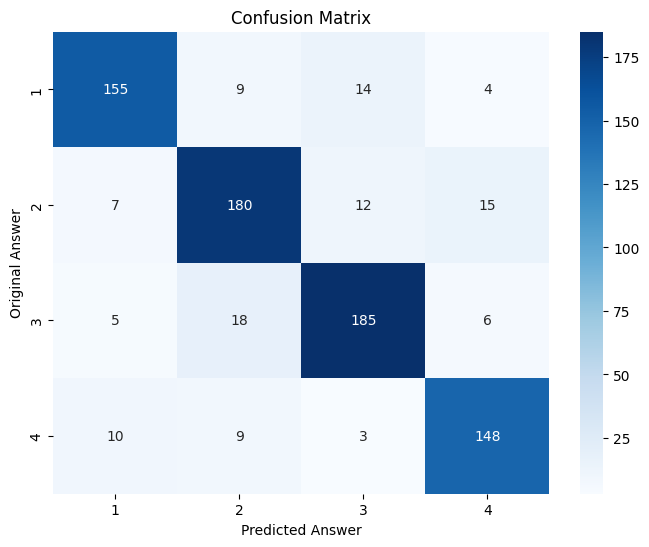

In [19]:
# Convert both 'Original Answer' and 'Predicted Answer' columns to string for compatibility
df_no_errors['Original Answer'] = df_no_errors['Original Answer'].astype(str)
df_no_errors['Predicted Answer'] = df_no_errors['Predicted Answer'].astype(str)

# Generate the classification report
report = classification_report(df_no_errors['Original Answer'], df_no_errors['Predicted Answer'], zero_division=1)

# Create confusion matrix
conf_matrix = confusion_matrix(df_no_errors['Original Answer'], df_no_errors['Predicted Answer'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['1', '2', '3', '4'], yticklabels=['1', '2', '3', '4'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Answer')
plt.ylabel('Original Answer')
plt.show()

In [20]:
print(report)

              precision    recall  f1-score   support

           1       0.88      0.85      0.86       182
           2       0.83      0.84      0.84       214
           3       0.86      0.86      0.86       214
           4       0.86      0.87      0.86       170

    accuracy                           0.86       780
   macro avg       0.86      0.86      0.86       780
weighted avg       0.86      0.86      0.86       780



In [21]:
# مقایسه پاسخ‌های صحیح و پیش‌بینی‌شده
df_no_errors['is_correct'] = df_no_errors['Original Answer'] == df_no_errors['Predicted Answer']

# محاسبه دقت کلی (درصد سوالات پاسخ داده شده به درستی)
accuracy = df_no_errors['is_correct'].mean()
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 85.64%


C:\Users\Active\AppData\Local\Temp\ipykernel_27208\3671576256.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_errors['is_correct'] = df_no_errors['Original Answer'] == df_no_errors['Predicted Answer']


## Check wrong predicts

In [24]:
# Function to display wrong predictions with RTL formatting for Passage and Question
def display_wrong_prediction(row):
    html = f"""
    <div style='border: 2px solid red; padding: 10px; margin-bottom: 10px;'>
        <p><strong>Row {row.name + 1}:</strong></p>
        <p><strong>Passage:</strong> <span style='direction: rtl; text-align: right; display: block;'>{row['Passage']}</span></p>
        <p><strong>Question:</strong> <span style='direction: rtl; text-align: right; display: block;'>{row['Question']}</span></p>
        <p><strong>Original Answer:</strong> {row['Original Answer']}</p>
        <p><strong>Predicted Answer:</strong> {row['Predicted Answer']}</p>
        <p><strong>Options:</strong> 
            <br>1: {row['Option 1']}
            <br>2: {row['Option 2']}
            <br>3: {row['Option 3']}
            <br>4: {row['Option 4']}
        </p>
    </div>
    """
    display(HTML(html))

# Display only the rows with wrong predictions
wrong_predictions = df_no_errors[df_no_errors['Original Answer'] != df_no_errors['Predicted Answer']]

# Apply the display function to all wrong predictions
for index, row in wrong_predictions.iterrows():
    display_wrong_prediction(row)



## Re-check with LLama

In [26]:
df_no_errors.to_csv('Cohere-no-error.csv')

In [28]:
wrong_predictions.to_csv('Cohere-wrong.csv')

In [29]:
wrong_predictions

,Passage,Question,Original Answer,Predicted Answer,Option 1,Option 2,Option 3,Option 4,is_correct
7,تقریباً تمام رایانه‌هایی که امروزه مورد استفاد...,با توجه به متن، کدام یک از موارد زیر مثالی از ...,3,4,1010,12001,10010,110101,False
10,وبلاگ‌ها همچنین می‌توانند به پیشرفت مهارت نوشت...,کدام یک از جنبه‌های وبلاگ‌نویسی به عنوان انگیز...,2,3,پاسخ فعالانه به مطالب اینترنتی,ضرورت اجتناب از انتقاد,تأمین علاقه مخاطبانشان,نیاز به همکاری و مشارکت,False
15,برای این دوره معمول است، قلعه Kirby Muxloe بیش...,کدام مورد توصیف دقیقی از قلعه Kirby Muxloe نیست؟,2,4,دیوارهای ضخیم قلعه به درخواست Lord Hastings سا...,به دلیل ماهیت صلح‌آمیز کشور در زمان ساخت به اس...,ساخت قلعه در آن دوره زمانی رایج نبود,برای مقاومت در برابر حملات طولانی‌مدت و خاصی س...,False
16,برای این دوره معمول است، قلعه Kirby Muxloe بیش...,کدام یک از ویژگی‌های ساخت‌وساز برای قلعه Kirby...,2,1,پنجره‌های بزرگ,بنیانی که برای مقاومت در حملات ساخته شده است,استحکاماتی کمتر‌ از برخی قلعه‌ها,دیوارهای نازک,False
28,گرچه هوش مصنوعی از دلالت ضمنی قوی بر داستان‌ها...,با توجه به متن، هوش مصنوعی اغلب با کدام یک از ...,3,4,خدمات مشتریان,برنامه‌ریزی و زمان‌بندی,داستان علمی-تخیلی,تشخیص دست‌خط,False
...,...,...,...,...,...,...,...,...,...
745,شرکت‌های هواپیمایی مانند Emirates، Etihad Airw...,هنگام مقایسه مظنه کلی کرایه به آفریقا با سفر د...,3,1,هزینه ویزاهای اضافی برای مکان‌های خارج از آفریقا,هزینه مالیات‌های عزیمت به آفریقا,هزینه ویزای آفریقا,هزینه حمل و نقل زمینی برای مکان‌های خارج از آف...,False
753,استفاده از برنامه‌های ناوبری GPS در تلفن هوشمن...,چه چیز دلیل خوبی برای استفاده از یک برنامه مسی...,1,4,نگران نبودن درباره اتصال داده,صرفه‌جویی در پول,اجتناب از اجاره,نیاز نداشتن به خرید نقشه‌های جدید,False
759,در بسیاری از نقاط جهان، دست تکان دادن یک حرکت ...,در مناطق روستایی مالزی، کدام ژست حرکتی به معنی...,2,1,خم کردن انگشت سبابه,دست تکان دادن,کف دست‌ها را به کف‌دست فرد دیگر زدن,انگشت شصت را بالا گرفتن,False
772,Jardín de la Unión. این فضا به عنوان اتاق میان...,مطابق با متن، کدام‌یک از موارد زیر در Jardín d...,2,4,یک بالکنی مرکزی با کنسرت,منزلگاه یک داستان عاشقانه قدیمی,رستوران‌های رو به باغ,یک ساختمان صومعه قدیمی,False


In [5]:
os.environ['GROQ_API_KEY'] = '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'

In [6]:
wrong_predictions = pd.read_csv('Cohere-wrong.csv')

In [7]:
wrong_predictions

,Unnamed: 0,Passage,Question,Original Answer,Predicted Answer,Option 1,Option 2,Option 3,Option 4,is_correct
0,7,تقریباً تمام رایانه‌هایی که امروزه مورد استفاد...,با توجه به متن، کدام یک از موارد زیر مثالی از ...,3,4,1010,12001,10010,110101,False
1,10,وبلاگ‌ها همچنین می‌توانند به پیشرفت مهارت نوشت...,کدام یک از جنبه‌های وبلاگ‌نویسی به عنوان انگیز...,2,3,پاسخ فعالانه به مطالب اینترنتی,ضرورت اجتناب از انتقاد,تأمین علاقه مخاطبانشان,نیاز به همکاری و مشارکت,False
2,15,برای این دوره معمول است، قلعه Kirby Muxloe بیش...,کدام مورد توصیف دقیقی از قلعه Kirby Muxloe نیست؟,2,4,دیوارهای ضخیم قلعه به درخواست Lord Hastings سا...,به دلیل ماهیت صلح‌آمیز کشور در زمان ساخت به اس...,ساخت قلعه در آن دوره زمانی رایج نبود,برای مقاومت در برابر حملات طولانی‌مدت و خاصی س...,False
3,16,برای این دوره معمول است، قلعه Kirby Muxloe بیش...,کدام یک از ویژگی‌های ساخت‌وساز برای قلعه Kirby...,2,1,پنجره‌های بزرگ,بنیانی که برای مقاومت در حملات ساخته شده است,استحکاماتی کمتر‌ از برخی قلعه‌ها,دیوارهای نازک,False
4,28,گرچه هوش مصنوعی از دلالت ضمنی قوی بر داستان‌ها...,با توجه به متن، هوش مصنوعی اغلب با کدام یک از ...,3,4,خدمات مشتریان,برنامه‌ریزی و زمان‌بندی,داستان علمی-تخیلی,تشخیص دست‌خط,False
...,...,...,...,...,...,...,...,...,...,...
107,745,شرکت‌های هواپیمایی مانند Emirates، Etihad Airw...,هنگام مقایسه مظنه کلی کرایه به آفریقا با سفر د...,3,1,هزینه ویزاهای اضافی برای مکان‌های خارج از آفریقا,هزینه مالیات‌های عزیمت به آفریقا,هزینه ویزای آفریقا,هزینه حمل و نقل زمینی برای مکان‌های خارج از آف...,False
108,753,استفاده از برنامه‌های ناوبری GPS در تلفن هوشمن...,چه چیز دلیل خوبی برای استفاده از یک برنامه مسی...,1,4,نگران نبودن درباره اتصال داده,صرفه‌جویی در پول,اجتناب از اجاره,نیاز نداشتن به خرید نقشه‌های جدید,False
109,759,در بسیاری از نقاط جهان، دست تکان دادن یک حرکت ...,در مناطق روستایی مالزی، کدام ژست حرکتی به معنی...,2,1,خم کردن انگشت سبابه,دست تکان دادن,کف دست‌ها را به کف‌دست فرد دیگر زدن,انگشت شصت را بالا گرفتن,False
110,772,Jardín de la Unión. این فضا به عنوان اتاق میان...,مطابق با متن، کدام‌یک از موارد زیر در Jardín d...,2,4,یک بالکنی مرکزی با کنسرت,منزلگاه یک داستان عاشقانه قدیمی,رستوران‌های رو به باغ,یک ساختمان صومعه قدیمی,False


In [11]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

# Function to check the API with custom parameters: model_name and temperature
def check_api_with_parameters(model_name, temperature):
    # Define the language model with the given model_name and temperature
    llm = ChatGroq(
        model=model_name,              # Your chosen model
        temperature=temperature,       # Set temperature to control randomness
        max_tokens=None,               # Depending on model capability
        timeout=None,                  # Timeout setting, if any
        max_retries=2                  # Retry in case of failed requests
    )
    return llm

# Function to predict the correct answer
def predict_answer(passage, question, options, llm):
    logging.info(f"Starting prediction for passage: {passage[:50]}... and question: {question}")
    try:
        # Define the messages for ChatGroq
        messages = [
            {
                "role": "system",
                "content": f"You are an expert assistant. Read the passage below and predict the correct answer based on the question.\n\nPassage:\n\n{passage}\n\nQuestion:\n{question}\n\nBased on the passage, predict the correct answer by selecting the corresponding number. (Only provide the correct number (1, 2, 3, or 4) as the answer.)"
            },
            {
                "role": "user",
                "content": f"Options:\n1. {options[0]}\n2. {options[1]}\n3. {options[2]}\n4. {options[3]}"
            }
        ]
        
        # Use invoke to get the result
        result = llm.invoke(messages)

        # Extract the predicted answer
        answer = result.content.strip()
        logging.info(f"Predicted answer: {answer}")
        return answer
    except Exception as e:
        logging.error(f"Error in predict_answer: {e}")
        return "error"

# Function to apply the prediction logic to the dataset and store the llama prediction in a new column
def recheck_wrong_predictions(df, model_name, temperature):
    # Check API with custom model_name and temperature
    llm = check_api_with_parameters(model_name, temperature)

    llama_predictions = []

    for index, row in df.iterrows():
        passage = row['Passage']
        question = row['Question']
        options = [row['Option 1'], row['Option 2'], row['Option 3'], row['Option 4']]
        original_answer = row['Original Answer']

        logging.info(f"Re-checking wrong prediction for row {index+1}")

        # Predict answer with retries
        llama_predicted_answer = make_request_with_retry(predict_answer, passage, question, options, llm)
        print("*" * 50)
        time.sleep(5)
        
        # Append the LLaMA prediction to the list
        llama_predictions.append(llama_predicted_answer)

        logging.info(f"Row {index+1}: LLaMA Predicted: {llama_predicted_answer}, Original: {original_answer}")

    # Add the LLaMA predictions as a new column in the original DataFrame
    df['llama_prediction'] = llama_predictions

    return df

In [14]:
model_name = "llama-3.1-70b-versatile"
temperature = 0.3

# Apply the LLaMA model to recheck wrong predictions
df_updated = recheck_wrong_predictions(wrong_predictions, model_name, temperature)

2024-10-26 10:22:34,767 - Re-checking wrong prediction for row 1
2024-10-26 10:22:34,767 - Starting prediction for passage: تقریباً تمام رایانه‌هایی که امروزه مورد استفاده قر... and question: با توجه به متن، کدام یک از موارد زیر مثالی از عدد دودویی پنج بیتی است؟
2024-10-26 10:22:38,846 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:22:38,853 - Predicted answer: 3


**************************************************


2024-10-26 10:22:43,859 - Row 1: LLaMA Predicted: 3, Original: 3
2024-10-26 10:22:43,859 - Re-checking wrong prediction for row 2
2024-10-26 10:22:43,859 - Starting prediction for passage: وبلاگ‌ها همچنین می‌توانند به پیشرفت مهارت نوشتن دا... and question: کدام یک از جنبه‌های وبلاگ‌نویسی به عنوان انگیزه‌ای برای بهبود مهارت نویسندگی دانش‌آموزان مطرح شده است؟
2024-10-26 10:22:44,326 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:22:44,326 - Predicted answer: 2


**************************************************


2024-10-26 10:22:49,334 - Row 2: LLaMA Predicted: 2, Original: 2
2024-10-26 10:22:49,335 - Re-checking wrong prediction for row 3
2024-10-26 10:22:49,335 - Starting prediction for passage: برای این دوره معمول است، قلعه Kirby Muxloe بیش از ... and question: کدام مورد توصیف دقیقی از قلعه Kirby Muxloe نیست؟
2024-10-26 10:22:53,436 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:22:53,436 - Predicted answer: 1


**************************************************


2024-10-26 10:22:58,446 - Row 3: LLaMA Predicted: 1, Original: 2
2024-10-26 10:22:58,447 - Re-checking wrong prediction for row 4
2024-10-26 10:22:58,448 - Starting prediction for passage: برای این دوره معمول است، قلعه Kirby Muxloe بیش از ... and question: کدام یک از ویژگی‌های ساخت‌وساز برای قلعه Kirby Muxloe در طول دوره زمانی توصیف‌شده در متن غیرعادی در نظر گرفته می‌شد؟
2024-10-26 10:23:02,685 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:23:02,685 - Predicted answer: 1


**************************************************


2024-10-26 10:23:07,691 - Row 4: LLaMA Predicted: 1, Original: 2
2024-10-26 10:23:07,692 - Re-checking wrong prediction for row 5
2024-10-26 10:23:07,692 - Starting prediction for passage: گرچه هوش مصنوعی از دلالت ضمنی قوی بر داستان‌های عل... and question: با توجه به متن، هوش مصنوعی اغلب با کدام یک از موارد زیر مرتبط است؟
2024-10-26 10:23:12,334 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:23:12,334 - Predicted answer: همه موارد ذکر شده در متن به هوش مصنوعی مرتبط هستند. با این حال، اگر بخواهیم یک پاسخ انتخاب کنیم که در متن به عنوان یک استفاده گسترده از هوش مصنوعی ذکر شده است، می‌توانیم گزینه 2 را انتخاب کنیم، اما گزینه 1 و 4 نیز مرتبط هستند. با این حال، گزینه 3 فقط یک دلالت ضمنی است و نه یک استفاده گسترده. گزینه 2 و 1 و 4 همگی مرتبط هستند. اما اگر بخواهیم یک پاسخ انتخاب کنیم، گزینه 2 در متن به عنوان یک نمونه از وظایف خودکار‌سازی ذکر شده است.

2


**************************************************


2024-10-26 10:23:17,339 - Row 5: LLaMA Predicted: همه موارد ذکر شده در متن به هوش مصنوعی مرتبط هستند. با این حال، اگر بخواهیم یک پاسخ انتخاب کنیم که در متن به عنوان یک استفاده گسترده از هوش مصنوعی ذکر شده است، می‌توانیم گزینه 2 را انتخاب کنیم، اما گزینه 1 و 4 نیز مرتبط هستند. با این حال، گزینه 3 فقط یک دلالت ضمنی است و نه یک استفاده گسترده. گزینه 2 و 1 و 4 همگی مرتبط هستند. اما اگر بخواهیم یک پاسخ انتخاب کنیم، گزینه 2 در متن به عنوان یک نمونه از وظایف خودکار‌سازی ذکر شده است.

2, Original: 3
2024-10-26 10:23:17,340 - Re-checking wrong prediction for row 6
2024-10-26 10:23:17,340 - Starting prediction for passage: در این دوره از تاریخ اروپا، کلیسای کاتولیک، که ثرو... and question: کدام یک از جنبه‌های زیر کلیسای کاتولیک مورد بررسی دقیق قرار نگرفت؟
2024-10-26 10:23:17,764 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:23:17,764 - Predicted answer: 4


**************************************************


2024-10-26 10:23:22,769 - Row 6: LLaMA Predicted: 4, Original: 2
2024-10-26 10:23:22,769 - Re-checking wrong prediction for row 7
2024-10-26 10:23:22,769 - Starting prediction for passage: تأثیرات اجتماعی و سیاسی بسیاری وجود دارد از جمله ا... and question: پس از انقلاب فرانسه، موفقیت در ارتش و سایر مشاغل کمتر از چه چیزی تأثیر می‌پذیرفت؟
2024-10-26 10:23:26,850 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:23:26,859 - Predicted answer: 2


**************************************************


2024-10-26 10:23:31,862 - Row 7: LLaMA Predicted: 2, Original: 2
2024-10-26 10:23:31,862 - Re-checking wrong prediction for row 8
2024-10-26 10:23:31,862 - Starting prediction for passage: جهش می‌تواند تأثیرات بسیار متفاوتی داشته باشد که ب... and question: بر اساس اطلاعات ارائه‌شده در متن، اثرات مختلف جهش‌ها بر چه چیزی متکی نیستند؟
2024-10-26 10:23:35,964 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:23:35,965 - Predicted answer: 4


**************************************************


2024-10-26 10:23:40,975 - Row 8: LLaMA Predicted: 4, Original: 1
2024-10-26 10:23:40,976 - Re-checking wrong prediction for row 9
2024-10-26 10:23:40,976 - Starting prediction for passage: به نظر می‌رسد که بزها ابتدا حدود 10,000 سال پیش در... and question: کدام یک از موارد زیر دلیلی بر نگهداری بز در فرهنگ‌های باستانی نبود؟
2024-10-26 10:23:45,068 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:23:45,068 - Predicted answer: 2


**************************************************


2024-10-26 10:23:50,083 - Row 9: LLaMA Predicted: 2, Original: 3
2024-10-26 10:23:50,083 - Re-checking wrong prediction for row 10
2024-10-26 10:23:50,083 - Starting prediction for passage: بشر هزاران هزار سال از عدسی‌ها برای بزرگ‌نمایی است... and question: چه مدت است که انسان‌ها با استفاده از لنز اجسام را بزرگ‌نمایی می‌کنند؟
2024-10-26 10:23:54,173 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:23:54,173 - Predicted answer: 3


**************************************************


2024-10-26 10:23:59,181 - Row 10: LLaMA Predicted: 3, Original: 2
2024-10-26 10:23:59,181 - Re-checking wrong prediction for row 11
2024-10-26 10:23:59,181 - Starting prediction for passage: علامت «کمان رو به بالا» مانند یک V است و «علامت کم... and question: با توجه به متن، کدام یک از موارد زیر مربوط به کشیدن آرشه نیست؟
2024-10-26 10:24:03,332 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:24:03,347 - Predicted answer: 2


**************************************************


2024-10-26 10:24:08,350 - Row 11: LLaMA Predicted: 2, Original: 1
2024-10-26 10:24:08,350 - Re-checking wrong prediction for row 12
2024-10-26 10:24:08,351 - Starting prediction for passage: هومینیدها برخلاف سایر نخستی‌سانان دیگر از دست‌هایش... and question: کدام یک از موارد زیر به طور دقیق بند انگشت‌های شامپانزه را توصیف می‌کند؟ 
2024-10-26 10:24:12,442 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:24:12,444 - Predicted answer: 3


**************************************************


2024-10-26 10:24:17,446 - Row 12: LLaMA Predicted: 3, Original: 3
2024-10-26 10:24:17,446 - Re-checking wrong prediction for row 13
2024-10-26 10:24:17,446 - Starting prediction for passage: در خارج از ساوانا، برآورده کردن نيازهاي مبتنی بر ا... and question: با توجه به متن، کدام یک از مشکلات زیر ناشی از کمبود اسیدهای آمینه ضروری نیست؟
2024-10-26 10:24:17,868 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:24:17,868 - Predicted answer: 1


**************************************************


2024-10-26 10:24:22,873 - Row 13: LLaMA Predicted: 1, Original: 1
2024-10-26 10:24:22,873 - Re-checking wrong prediction for row 14
2024-10-26 10:24:22,873 - Starting prediction for passage: اختلال در خواب فرآیند بیداری آگاهانه در طول خواب م... and question: پس از بیدار شدن هدفمند در طول دوره خواب طبیعی، کدام یک از این موارد در روند قطع خواب اختلال ایجاد می‌کند؟
2024-10-26 10:24:27,030 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:24:27,030 - Predicted answer: 2


**************************************************


2024-10-26 10:24:32,033 - Row 14: LLaMA Predicted: 2, Original: 1
2024-10-26 10:24:32,033 - Re-checking wrong prediction for row 15
2024-10-26 10:24:32,033 - Starting prediction for passage: اختلال در خواب فرآیند بیداری آگاهانه در طول خواب م... and question: کدام یک از موارد زیر توصیف دقیقی از وقفه خواب نیست؟
2024-10-26 10:24:36,085 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:24:36,085 - Predicted answer: 4


**************************************************


2024-10-26 10:24:41,100 - Row 15: LLaMA Predicted: 4, Original: 4
2024-10-26 10:24:41,100 - Re-checking wrong prediction for row 16
2024-10-26 10:24:41,100 - Starting prediction for passage: تیم‌های مجازی هم همان معیارهای تعالی تیم‌های معمول... and question: بر اساس متن، کدام جمله درباره تیم‌های فیزیکی و مجازی صحت ندارد؟
2024-10-26 10:24:45,252 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:24:45,252 - Predicted answer: 3


**************************************************


2024-10-26 10:24:50,258 - Row 16: LLaMA Predicted: 3, Original: 1
2024-10-26 10:24:50,258 - Re-checking wrong prediction for row 17
2024-10-26 10:24:50,258 - Starting prediction for passage: قانون بسیار آزار دهنده و مسخره یک سوم یک راهنمایی ... and question: کدام یک از موارد زیر مشمول قانون یک سوم نیست؟
2024-10-26 10:24:50,633 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:24:50,633 - Predicted answer: 2


**************************************************


2024-10-26 10:24:55,647 - Row 17: LLaMA Predicted: 2, Original: 1
2024-10-26 10:24:55,647 - Re-checking wrong prediction for row 18
2024-10-26 10:24:55,647 - Starting prediction for passage: به عنوان مثال، رایج ترین قالب عکاسی تصویر ثابت در ... and question: کدام یک از موارد زیر قالب عکاسی 35 میلی‌متر را توصیف نمی‌کند؟
2024-10-26 10:24:59,729 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:24:59,730 - Predicted answer: 3


**************************************************


2024-10-26 10:25:04,735 - Row 18: LLaMA Predicted: 3, Original: 3
2024-10-26 10:25:04,735 - Re-checking wrong prediction for row 19
2024-10-26 10:25:04,736 - Starting prediction for passage: عیب لنزهای بزرگنما این است که پیچیدگی کانونی و تعد... and question: بر اساس اطلاعات موجود در متن، چه زمانی ممکن است لنز بزرگنما به لنز اولیه ارجحیت داشته باشد؟
2024-10-26 10:25:08,840 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:25:08,840 - Predicted answer: 3


**************************************************


2024-10-26 10:25:13,857 - Row 19: LLaMA Predicted: 3, Original: 4
2024-10-26 10:25:13,857 - Re-checking wrong prediction for row 20
2024-10-26 10:25:13,857 - Starting prediction for passage: تمدن دره ایندوس تمدن عصر برنز در شمال غربی شبه قار... and question: با توجه به متن، کدام مکان با تمدن دره ایندوس مرتبط نیست؟
2024-10-26 10:25:17,946 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:25:17,946 - Predicted answer: 3


**************************************************


2024-10-26 10:25:22,961 - Row 20: LLaMA Predicted: 3, Original: 3
2024-10-26 10:25:22,961 - Re-checking wrong prediction for row 21
2024-10-26 10:25:22,961 - Starting prediction for passage: تمدن دره ایندوس تمدن عصر برنز در شمال غربی شبه قار... and question: کدام یک از موارد زیر به عنوان نام احتمالی تمدن عصر برنز مورد بحث در متن ذکر نشده است؟
2024-10-26 10:25:27,075 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:25:27,077 - Predicted answer: 3


**************************************************


2024-10-26 10:25:32,082 - Row 21: LLaMA Predicted: 3, Original: 3
2024-10-26 10:25:32,082 - Re-checking wrong prediction for row 22
2024-10-26 10:25:32,082 - Starting prediction for passage: ماهیت نظامی‌گرای امپراتوری روم به توسعه پیشرفت‌های... and question: کدام درمان یا عمل پزشکی مورد استفاده پزشکان و جراحان در دوران امپراتوری روم ذکر نشده است؟
2024-10-26 10:25:36,189 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:25:36,204 - Predicted answer: 1


**************************************************


2024-10-26 10:25:41,215 - Row 22: LLaMA Predicted: 1, Original: 1
2024-10-26 10:25:41,215 - Re-checking wrong prediction for row 23
2024-10-26 10:25:41,215 - Starting prediction for passage: با این حال، در ماه ژوئن 1956، وقتی طی آشوب‌های لهس... and question: کدام یک از موارد زیر علت شورش در لهستان نبود؟
2024-10-26 10:25:45,300 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:25:45,301 - Predicted answer: 4


**************************************************


2024-10-26 10:25:50,308 - Row 23: LLaMA Predicted: 4, Original: 4
2024-10-26 10:25:50,308 - Re-checking wrong prediction for row 24
2024-10-26 10:25:50,308 - Starting prediction for passage: آلمان دشمن مشترکی در جنگ جهانی دوم بود که منجر به ... and question: با توجه به متن، کدام یک از موارد زیر بر روابط بین اتحاد جماهیر شوروی و ایالات متحده تأثیری نداشت؟
2024-10-26 10:25:50,699 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:25:50,699 - Predicted answer: 2


**************************************************


2024-10-26 10:25:55,706 - Row 24: LLaMA Predicted: 2, Original: 2
2024-10-26 10:25:55,707 - Re-checking wrong prediction for row 25
2024-10-26 10:25:55,708 - Starting prediction for passage: هرم بزرگ جیزه تنها بازمانده عجایب هفتگانه است که ه... and question: چه چیزی را می‌توان در فلات جیزه پیدا کرد؟
2024-10-26 10:26:00,040 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:26:00,041 - Predicted answer: 4


**************************************************


2024-10-26 10:26:05,043 - Row 25: LLaMA Predicted: 4, Original: 3
2024-10-26 10:26:05,044 - Re-checking wrong prediction for row 26
2024-10-26 10:26:05,044 - Starting prediction for passage: استفاده از کشتی‌ها برای حمل و نقل کالا به‌مراتب کا... and question: نیروی دریایی آلمان در طول جنگ جهانی دوم در تلاش بود تا چه کاری انجام دهد؟
2024-10-26 10:26:05,494 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:26:05,496 - Predicted answer: 4


**************************************************


2024-10-26 10:26:10,501 - Row 26: LLaMA Predicted: 4, Original: 2
2024-10-26 10:26:10,501 - Re-checking wrong prediction for row 27
2024-10-26 10:26:10,501 - Starting prediction for passage: دروکگیال دزونگ یک قلعه مخروبه و صومعه بودایی است ک... and question: کدام جمله درباره دروکگیال دزونگ درست نیست؟
2024-10-26 10:26:14,642 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:26:14,643 - Predicted answer: 3


**************************************************


2024-10-26 10:26:19,646 - Row 27: LLaMA Predicted: 3, Original: 1
2024-10-26 10:26:19,646 - Re-checking wrong prediction for row 28
2024-10-26 10:26:19,646 - Starting prediction for passage: شروع تایوان به قرن 15ام بر می‌گردد، آن زمان که ملو... and question: کمپانی Dutch East India در مدت زمانی که در تایوان بود، کدام کار را انجام نداد؟
2024-10-26 10:26:23,762 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:26:23,762 - Predicted answer: 4


**************************************************


2024-10-26 10:26:28,767 - Row 28: LLaMA Predicted: 4, Original: 4
2024-10-26 10:26:28,767 - Re-checking wrong prediction for row 29
2024-10-26 10:26:28,767 - Starting prediction for passage: ببر همانند یک ورزشکار شش‌دنگ، می‌تواند صعود کند (ه... and question: کدام مورد از قدرت‌های برتر ببر در نظر گرفته نمی‌شود؟
2024-10-26 10:26:32,918 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:26:32,918 - Predicted answer: 3


**************************************************


2024-10-26 10:26:37,921 - Row 29: LLaMA Predicted: 3, Original: 2
2024-10-26 10:26:37,922 - Re-checking wrong prediction for row 30
2024-10-26 10:26:37,922 - Starting prediction for passage: قسمت اروپایی ترکیه (تراکیه شرقی یا روملی در شبه‌جز... and question: با توجه به متن، طول ترکیه حدود چند مایل است؟
2024-10-26 10:26:38,340 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:26:38,342 - Predicted answer: 4.


**************************************************


2024-10-26 10:26:43,345 - Row 30: LLaMA Predicted: 4., Original: 4
2024-10-26 10:26:43,345 - Re-checking wrong prediction for row 31
2024-10-26 10:26:43,345 - Starting prediction for passage: تقریباً در هر خانه ای در شهرهای هاراپا و موهنجو-دا... and question: سیستم‌های فاضلاب پیشرفته در کدام یک از مناطق زیر یافت شد؟
2024-10-26 10:26:43,728 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:26:43,728 - Predicted answer: 1


**************************************************


2024-10-26 10:26:48,728 - Row 31: LLaMA Predicted: 1, Original: 1
2024-10-26 10:26:48,728 - Re-checking wrong prediction for row 32
2024-10-26 10:26:48,728 - Starting prediction for passage: در حدود قرن 15، شمال استونی به شدت تحت تأثیر فرهنگ... and question: آلمان از چه زمانی در تاریخ تأثیر فرهنگی شدیدی بر استونی گذاشت؟
2024-10-26 10:26:49,109 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:26:49,109 - Predicted answer: 3


**************************************************


2024-10-26 10:26:54,115 - Row 32: LLaMA Predicted: 3, Original: 3
2024-10-26 10:26:54,116 - Re-checking wrong prediction for row 33
2024-10-26 10:26:54,116 - Starting prediction for passage: هانگول تنها الفبای ابداعی هدفمند با کاربرد روزانه ... and question: کدام مورد حقیقتی صحیح درباره الفبای هانگول نیست؟
2024-10-26 10:26:58,613 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:26:58,613 - Predicted answer: 2


**************************************************


2024-10-26 10:27:03,623 - Row 33: LLaMA Predicted: 2, Original: 1
2024-10-26 10:27:03,623 - Re-checking wrong prediction for row 34
2024-10-26 10:27:03,623 - Starting prediction for passage: نیروی جاذبه ایو چطور روی من تاثیر خواهد داشت؟ اگر ... and question: با توجه به متن، کدام مورد در رابطه با نیروی جاذبه روی ایو صحیح است؟
2024-10-26 10:27:07,768 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:27:07,768 - Predicted answer: 4


**************************************************


2024-10-26 10:27:12,774 - Row 34: LLaMA Predicted: 4, Original: 4
2024-10-26 10:27:12,774 - Re-checking wrong prediction for row 35
2024-10-26 10:27:12,775 - Starting prediction for passage: در خلال جنگ انقلابی، نخست سیزده ایالت تحت اصول کنف... and question: با توجه به متن، کدام یک از موارد زیر در هنگام تلاش برای اعمال قوانین خاص مورد توجه برای سیزده ایالت نبود؟
2024-10-26 10:27:13,615 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:27:13,615 - Predicted answer: 4


**************************************************


2024-10-26 10:27:18,622 - Row 35: LLaMA Predicted: 4, Original: 1
2024-10-26 10:27:18,622 - Re-checking wrong prediction for row 36
2024-10-26 10:27:18,622 - Starting prediction for passage: در خلال جنگ انقلابی، نخست سیزده ایالت تحت اصول کنف... and question: با توجه به متن، کدام عبارت وضعیت حکومت مرکزی در دوران جنگ انقلابی را به درستی نشان می‌دهد؟
2024-10-26 10:27:22,745 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:27:22,745 - Predicted answer: 1


**************************************************


2024-10-26 10:27:27,753 - Row 36: LLaMA Predicted: 1, Original: 3
2024-10-26 10:27:27,753 - Re-checking wrong prediction for row 37
2024-10-26 10:27:27,753 - Starting prediction for passage: گرچه ساخت اهرام سنگی تا پایان پادشاهی کهن ادامه دا... and question: طبق این متن، پادشاهی جدید مصریان احتمالاً از کدام ویژگی اهرام جیزه شگفت زده نمی‌شوند؟
2024-10-26 10:27:31,783 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:27:31,783 - Predicted answer: 1


**************************************************


2024-10-26 10:27:36,789 - Row 37: LLaMA Predicted: 1, Original: 2
2024-10-26 10:27:36,789 - Re-checking wrong prediction for row 38
2024-10-26 10:27:36,790 - Starting prediction for passage: سالانه تقریباً 1.5 میلیون علف‌خوار حدود اکتبر از س... and question: با توجه به متن، علف‌خواران به دنبال باران به کجا سفر می‌کنند؟
2024-10-26 10:27:37,181 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:27:37,181 - Predicted answer: 3


**************************************************


2024-10-26 10:27:42,186 - Row 38: LLaMA Predicted: 3, Original: 2
2024-10-26 10:27:42,188 - Re-checking wrong prediction for row 39
2024-10-26 10:27:42,188 - Starting prediction for passage: اجازه دهید ابتدا درباره طرح‌های ایتالیا توضیح دهیم... and question: چه چیزی به عنوان مرحله ضروری در طرح ایتالیا برای تصرف کشورهای آفریقایی ذکر نشده است؟
2024-10-26 10:27:46,298 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:27:46,300 - Predicted answer: 2


**************************************************


2024-10-26 10:27:51,308 - Row 39: LLaMA Predicted: 2, Original: 2
2024-10-26 10:27:51,309 - Re-checking wrong prediction for row 40
2024-10-26 10:27:51,309 - Starting prediction for passage: تا هفدهم سپتامبر سال 1939، دفاع کشور لهستان درهم ش... and question: کدام یک از موارد زیر توسط ارتش سرخ انجام نشد؟
2024-10-26 10:27:51,691 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:27:51,699 - Predicted answer: 2


**************************************************


2024-10-26 10:27:56,706 - Row 40: LLaMA Predicted: 2, Original: 3
2024-10-26 10:27:56,706 - Re-checking wrong prediction for row 41
2024-10-26 10:27:56,706 - Starting prediction for passage: این جشن‌ها با برنامه ویژه‌ای از گروه «سیرک آفتاب» ... and question: دومین اجرای آخر شب چه بود؟
2024-10-26 10:28:00,804 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:28:00,804 - Predicted answer: 3


**************************************************


2024-10-26 10:28:05,811 - Row 41: LLaMA Predicted: 3, Original: 1
2024-10-26 10:28:05,811 - Re-checking wrong prediction for row 42
2024-10-26 10:28:05,811 - Starting prediction for passage: اخبار منتشر شده در رد لایک امروز اختصاص داشت به مر... and question: با توجه به متن، در حالی که اخباری مبنی بر دستگیری فردی دیگر منتشر می‌شد، مراسم تشییع جنازه چند قربانی برگزار می‌شد؟
2024-10-26 10:28:06,227 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:28:06,227 - Predicted answer: 2


**************************************************


2024-10-26 10:28:11,241 - Row 42: LLaMA Predicted: 2, Original: 4
2024-10-26 10:28:11,242 - Re-checking wrong prediction for row 43
2024-10-26 10:28:11,242 - Starting prediction for passage: حدود 60 مورد گرمای بیش از حد آیپاد‌ها گزارش شده اس... and question: چند نفر در اثر حادثه‌های گرمای بیش از حد iPod مجروح شدند؟
2024-10-26 10:28:15,931 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:28:15,931 - Predicted answer: 1


**************************************************


2024-10-26 10:28:20,937 - Row 43: LLaMA Predicted: 1, Original: 1
2024-10-26 10:28:20,938 - Re-checking wrong prediction for row 44
2024-10-26 10:28:20,938 - Starting prediction for passage: پیتر کاستلو، خزانه دار استرالیایی و مردی که به احت... and question: رهبر حزب لیبرال استرالیا کیست؟
2024-10-26 10:28:25,061 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:28:25,068 - Predicted answer: 1


**************************************************


2024-10-26 10:28:30,075 - Row 44: LLaMA Predicted: 1, Original: 2
2024-10-26 10:28:30,076 - Re-checking wrong prediction for row 45
2024-10-26 10:28:30,076 - Starting prediction for passage: از آنجایی که فقط هجده مدال در روز وجود دارد، بسیار... and question: کدام کشور در مسابقات Super-G کلاس ایستاده زنان دهم شد؟
2024-10-26 10:28:34,601 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:28:34,602 - Predicted answer: None of the options are correct. The passage does not mention the country that came in 10th place in the Super-G standing women's competition. However, based on the given options and the passage, the closest answer would be:

2. هلند

But this is not correct because the passage mentions that هلند (Holland) came in 9th place in the اسکی مارپیچ سرعت زنان (Women's Slalom Speed) competition, not the Super-G standing women's competition.


**************************************************


2024-10-26 10:28:39,607 - Row 45: LLaMA Predicted: None of the options are correct. The passage does not mention the country that came in 10th place in the Super-G standing women's competition. However, based on the given options and the passage, the closest answer would be:

2. هلند

But this is not correct because the passage mentions that هلند (Holland) came in 9th place in the اسکی مارپیچ سرعت زنان (Women's Slalom Speed) competition, not the Super-G standing women's competition., Original: 1
2024-10-26 10:28:39,607 - Re-checking wrong prediction for row 46
2024-10-26 10:28:39,607 - Starting prediction for passage: نیجریه پیش‌تر اعلام کرد قصد داشت در هفته منتهی به ... and question: کدام مورد توسط «آلبرت موچانگا» به عنوان موضوعی که هنوز نیاز به توافق داشت، ذکر نشده است؟
2024-10-26 10:28:43,684 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:28:43,687 - Predicted answer: 2


**************************************************


2024-10-26 10:28:48,693 - Row 46: LLaMA Predicted: 2, Original: 1
2024-10-26 10:28:48,694 - Re-checking wrong prediction for row 47
2024-10-26 10:28:48,694 - Starting prediction for passage: او در زمان اقامت در آتلانتا تحسین منتقدان را برانگ... and question: با توجه به متن، چه چیزی در گزارش آتلانتا ژورنال-کانستیتیوشن ذکر نشده است؟
2024-10-26 10:28:52,841 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:28:52,841 - Predicted answer: 3


**************************************************


2024-10-26 10:28:57,847 - Row 47: LLaMA Predicted: 3, Original: 1
2024-10-26 10:28:57,848 - Re-checking wrong prediction for row 48
2024-10-26 10:28:57,848 - Starting prediction for passage: یک پانسیون در مکه، شهر مقدس اسلام، حدود ساعت 10 ام... and question: کدام جمله درباره مهمانان هاستل درست نیست؟
2024-10-26 10:29:01,960 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:29:01,962 - Predicted answer: 4


**************************************************


2024-10-26 10:29:06,969 - Row 48: LLaMA Predicted: 4, Original: 4
2024-10-26 10:29:06,969 - Re-checking wrong prediction for row 49
2024-10-26 10:29:06,970 - Starting prediction for passage: این ماهواره‌ها که هر دو وزن‌شان بیش از 1000 پوند ا... and question: با توجه به متن، چه اطلاعاتی درباره برخورد نامعلوم نیست؟
2024-10-26 10:29:11,067 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:29:11,067 - Predicted answer: 3


**************************************************


2024-10-26 10:29:16,073 - Row 49: LLaMA Predicted: 3, Original: 2
2024-10-26 10:29:16,074 - Re-checking wrong prediction for row 50
2024-10-26 10:29:16,074 - Starting prediction for passage: اگرچه هنگام برخورد ماشین به خانه سه نفر در آنجا بو... and question: چه اتفاقی برای راننده درگیر در تصادف نیفتاد؟
2024-10-26 10:29:16,495 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:29:16,496 - Predicted answer: 2


**************************************************


2024-10-26 10:29:21,504 - Row 50: LLaMA Predicted: 2, Original: 3
2024-10-26 10:29:21,505 - Re-checking wrong prediction for row 51
2024-10-26 10:29:21,505 - Starting prediction for passage: مقامات ایالت اوهایو می گویند، یک پزشک که در بیمارس... and question: نسبت دکتر مالار بالاسوبرامانیان با ساروجا بالاسوبرامانیان چه بود؟
2024-10-26 10:29:25,574 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:29:25,575 - Predicted answer: 3


**************************************************


2024-10-26 10:29:30,583 - Row 51: LLaMA Predicted: 3, Original: 2
2024-10-26 10:29:30,584 - Re-checking wrong prediction for row 52
2024-10-26 10:29:30,584 - Starting prediction for passage: این بزرگترین اکتساب مالکیت در تاریخچه eBay است. ای... and question: eBay با این اکتساب مالکیت در پی چه چیزی است؟
2024-10-26 10:29:35,103 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:29:35,104 - Predicted answer: 3. افزایش محبوبیت خود


**************************************************


2024-10-26 10:29:40,105 - Row 52: LLaMA Predicted: 3. افزایش محبوبیت خود, Original: 2
2024-10-26 10:29:40,105 - Re-checking wrong prediction for row 53
2024-10-26 10:29:40,105 - Starting prediction for passage: وقتی درگیری متوقف شد و زخمی‌ها به بیمارستان انتقال... and question: با توجه به متن، چه کسانی با زندانیانی که پس از درگیری در حیاط ماندند تعاملی نداشتند؟
2024-10-26 10:29:41,071 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:29:41,073 - Predicted answer: 4


**************************************************


2024-10-26 10:29:46,077 - Row 53: LLaMA Predicted: 4, Original: 4
2024-10-26 10:29:46,078 - Re-checking wrong prediction for row 54
2024-10-26 10:29:46,078 - Starting prediction for passage: گزارش‌های تلویزیونی حاکی از وجود دود سفید بر فراز ... and question: با توجه به متن، کدام یک از موارد زیر احتمالاً منجر به شرایط خطرناک در داخل و اطراف کارخانه شده است؟
2024-10-26 10:29:50,201 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:29:50,201 - Predicted answer: 2


**************************************************


2024-10-26 10:29:55,209 - Row 54: LLaMA Predicted: 2, Original: 1
2024-10-26 10:29:55,209 - Re-checking wrong prediction for row 55
2024-10-26 10:29:55,209 - Starting prediction for passage: یکی از شایع‌ترین مشکلات هنگام تبدیل کردن فیلم به ق... and question: با توجه به متن، هنگام تبدیل فیلم به فرمت DVD ممکن است با کدام یک از مشکلات زیر مواجه شوید؟
2024-10-26 10:29:59,313 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:29:59,313 - Predicted answer: 2


**************************************************


2024-10-26 10:30:04,314 - Row 55: LLaMA Predicted: 2, Original: 2
2024-10-26 10:30:04,314 - Re-checking wrong prediction for row 56
2024-10-26 10:30:04,314 - Starting prediction for passage: اروپا قاره‌ای نسبتاً کوچک است ولی در آن کشورهای مس... and question: کدام‌یک از موارد زیر یک مزیت سفر در منطقه شینگن است؟
2024-10-26 10:30:08,442 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:30:08,443 - Predicted answer: 1، 2 و 3


**************************************************


2024-10-26 10:30:13,449 - Row 56: LLaMA Predicted: 1، 2 و 3, Original: 3
2024-10-26 10:30:13,449 - Re-checking wrong prediction for row 57
2024-10-26 10:30:13,450 - Starting prediction for passage: سفر به Walt Disney World سیاحت بزرگی برای بسیاری ا... and question: مطابق با متن، چه چیز ممکن است در مورد سفر معمول به Walt Disney World غیرمعمول تلقی شود؟
2024-10-26 10:30:14,541 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:30:14,541 - Predicted answer: 3


**************************************************


2024-10-26 10:30:19,549 - Row 57: LLaMA Predicted: 3, Original: 2
2024-10-26 10:30:19,549 - Re-checking wrong prediction for row 58
2024-10-26 10:30:19,549 - Starting prediction for passage: هر شخصی که قصد بازدید از کشوری را دارد که منطقه جن... and question: مطابق با متن، کدام‌یک از مشکلات زیر به احتمال زیاد در یک کلاس آموزش حرفه‌ای یا در انتشارات تحت پوشش نیست؟
2024-10-26 10:30:23,676 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:30:23,678 - Predicted answer: 1


**************************************************


2024-10-26 10:30:28,685 - Row 58: LLaMA Predicted: 1, Original: 3
2024-10-26 10:30:28,685 - Re-checking wrong prediction for row 59
2024-10-26 10:30:28,685 - Starting prediction for passage: در شمال، این منطقه توسط ساحل صحرا و از جنوب و غرب ... and question: مطابق با متن، کدام‌یک از موارد زیر نکته خوبی برای زنانی که در این محل مسافرت می‌کنند نخواهد بود؟
2024-10-26 10:30:29,098 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:30:29,100 - Predicted answer: 1


**************************************************


2024-10-26 10:30:34,107 - Row 59: LLaMA Predicted: 1, Original: 1
2024-10-26 10:30:34,107 - Re-checking wrong prediction for row 60
2024-10-26 10:30:34,107 - Starting prediction for passage: به‌طورکلی کار در خارج از کشور به این معنی است که ب... and question: چه چیز احتمالاً درباره مالیات بر درآمد در کشورهای مختلف یکپارچه می‌ماند؟
2024-10-26 10:30:38,206 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:30:38,206 - Predicted answer: 2


**************************************************


2024-10-26 10:30:43,212 - Row 60: LLaMA Predicted: 2, Original: 3
2024-10-26 10:30:43,212 - Re-checking wrong prediction for row 61
2024-10-26 10:30:43,212 - Starting prediction for passage: به‌طورکلی کار در خارج از کشور به این معنی است که ب... and question: مطابق با متن، اگر در خارج کار می‌کنید، اما درجای دیگر مستقر هستید، مالیات‌های بر درآمد خود را احتمالاً در کجا ثبت خواهید کرد؟
2024-10-26 10:30:43,920 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:30:43,920 - Predicted answer: 3


**************************************************


2024-10-26 10:30:48,927 - Row 61: LLaMA Predicted: 3, Original: 1
2024-10-26 10:30:48,927 - Re-checking wrong prediction for row 62
2024-10-26 10:30:48,927 - Starting prediction for passage: لونو هنگام از کار افتادن، 120-160 متر مکعب سوخت دا... and question: با توجه به این متن، نگرانی اولیه مسئولان درباره لونو چه بود؟
2024-10-26 10:30:53,008 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:30:53,008 - Predicted answer: 3


**************************************************


2024-10-26 10:30:58,014 - Row 62: LLaMA Predicted: 3, Original: 3
2024-10-26 10:30:58,014 - Re-checking wrong prediction for row 63
2024-10-26 10:30:58,015 - Starting prediction for passage: بیش از چهار میلیون نفر برای حضور در مراسم خاکسپاری... and question: در کجا نمایشگر تلویزیونی برای مراسم خاکسپاری نصب نشده بود؟
2024-10-26 10:31:02,101 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:31:02,102 - Predicted answer: 4


**************************************************


2024-10-26 10:31:07,111 - Row 63: LLaMA Predicted: 4, Original: 4
2024-10-26 10:31:07,111 - Re-checking wrong prediction for row 64
2024-10-26 10:31:07,111 - Starting prediction for passage: بیش از چهار میلیون نفر برای حضور در مراسم خاکسپاری... and question: مراسم خاکسپاری کجا برگزار شد؟
2024-10-26 10:31:07,522 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:31:07,524 - Predicted answer: 3


**************************************************


2024-10-26 10:31:12,525 - Row 64: LLaMA Predicted: 3, Original: 3
2024-10-26 10:31:12,525 - Re-checking wrong prediction for row 65
2024-10-26 10:31:12,525 - Starting prediction for passage: براساس گزارش‌ها، یک آپارتمان در خیابان مکبث به دلی... and question: پس از انفجار، چه کسانی به دلیل جراحات جدی تحت درمان قرار گرفتند؟
2024-10-26 10:31:12,925 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:31:12,925 - Predicted answer: 2


**************************************************


2024-10-26 10:31:17,931 - Row 65: LLaMA Predicted: 2, Original: 2
2024-10-26 10:31:17,931 - Re-checking wrong prediction for row 66
2024-10-26 10:31:17,932 - Starting prediction for passage: دولت ایرلند بر فوریت قانون‌گذاری پارلمان در جهت اص... and question: دولت ایرلند درحال برنامه‌ریزی برای چه چیزی است؟
2024-10-26 10:31:18,347 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:31:18,348 - Predicted answer: 4


**************************************************


2024-10-26 10:31:23,353 - Row 66: LLaMA Predicted: 4, Original: 2
2024-10-26 10:31:23,354 - Re-checking wrong prediction for row 67
2024-10-26 10:31:23,355 - Starting prediction for passage: یک پلیس سابق فیلیپینی با ربودن یک اتوبوس در مانیل،... and question: با توجه به متن، رولاندو مندوزا چه کسی را گروگان نگرفت؟
2024-10-26 10:31:23,754 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:31:23,756 - Predicted answer: 1


**************************************************


2024-10-26 10:31:28,760 - Row 67: LLaMA Predicted: 1, Original: 2
2024-10-26 10:31:28,760 - Re-checking wrong prediction for row 68
2024-10-26 10:31:28,760 - Starting prediction for passage: یک پلیس سابق فیلیپینی با ربودن یک اتوبوس در مانیل،... and question: با توجه به متن، آزادی زودهنگام کدام گروگان‌ها تأیید نشد؟
2024-10-26 10:31:29,160 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:31:29,160 - Predicted answer: 1


**************************************************


2024-10-26 10:31:34,166 - Row 68: LLaMA Predicted: 1, Original: 1
2024-10-26 10:31:34,166 - Re-checking wrong prediction for row 69
2024-10-26 10:31:34,166 - Starting prediction for passage: پنج دقیقه از زمان نمایش بادی شروع به وزش می کند، ح... and question: طبق روایت آرمند ورساچه، دقیقاً قبل از واکنش جمعیت به آب‌وهوا چه اتفاقی افتاد؟
2024-10-26 10:31:34,574 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:31:34,575 - Predicted answer: 1


**************************************************


2024-10-26 10:31:39,581 - Row 69: LLaMA Predicted: 1, Original: 1
2024-10-26 10:31:39,581 - Re-checking wrong prediction for row 70
2024-10-26 10:31:39,581 - Starting prediction for passage: پنج دقیقه از زمان نمایش بادی شروع به وزش می کند، ح... and question: به گفته ورساچه* چه زمانی شدیدترین بادها شروع به وزیدن کردند؟
2024-10-26 10:31:43,721 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:31:43,721 - Predicted answer: 1


**************************************************


2024-10-26 10:31:48,727 - Row 70: LLaMA Predicted: 1, Original: 4
2024-10-26 10:31:48,727 - Re-checking wrong prediction for row 71
2024-10-26 10:31:48,727 - Starting prediction for passage: به گفته هواشناسان، این طوفان، که در حدود 645 مایلی... and question: پیش از «فرِد»، چند طوفان بزرگ در شرق 35 درجه غربی ثبت شده بود؟
2024-10-26 10:31:49,127 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:31:49,127 - Predicted answer: 2


**************************************************


2024-10-26 10:31:54,133 - Row 71: LLaMA Predicted: 2, Original: 3
2024-10-26 10:31:54,134 - Re-checking wrong prediction for row 72
2024-10-26 10:31:54,134 - Starting prediction for passage: برنده مدال طلای المپیک در شنای 100 متر و 200 متر آ... and question: وی دارنده مدال طلای المپیک به دلیل شنا در بازی‌های مشترک المنافع چند رویداد بود؟
2024-10-26 10:31:54,507 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:31:54,517 - Predicted answer: 2


**************************************************


2024-10-26 10:31:59,522 - Row 72: LLaMA Predicted: 2, Original: 1
2024-10-26 10:31:59,522 - Re-checking wrong prediction for row 73
2024-10-26 10:31:59,522 - Starting prediction for passage: امروز گروه تحقیقاتی عراق گزارش خود را رأس ساعت 12:... and question: کدام مورد در گزارش گروه تحقیقاتی عراق قید نشده بود؟
2024-10-26 10:32:03,629 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:32:03,637 - Predicted answer: 2


**************************************************


2024-10-26 10:32:08,651 - Row 73: LLaMA Predicted: 2, Original: 2
2024-10-26 10:32:08,651 - Re-checking wrong prediction for row 74
2024-10-26 10:32:08,651 - Starting prediction for passage: پس از این مسابقه، «کسلوفسکی» با 2250 امتیاز صدرنشی... and question: با درنظر گرفتن چهار رقابت باقیمانده در فصل، چه کسی رده چهارم را در مسابقه قهرمانی رانندگان دارد؟
2024-10-26 10:32:12,729 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:32:12,729 - Predicted answer: 4


**************************************************


2024-10-26 10:32:17,741 - Row 74: LLaMA Predicted: 4, Original: 4
2024-10-26 10:32:17,741 - Re-checking wrong prediction for row 75
2024-10-26 10:32:17,741 - Starting prediction for passage: میت رومنی، فرماندار سابق ماساچوست، روز سه‌شنبه با ... and question: به‌دلیل وضعیت فلوریدا به‌عنوان یک ایالت همیشه برنده، به میت رومنی چه چیز جایزه داده شد؟
2024-10-26 10:32:21,829 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:32:21,829 - Predicted answer: 2


**************************************************


2024-10-26 10:32:26,843 - Row 75: LLaMA Predicted: 2, Original: 3
2024-10-26 10:32:26,845 - Re-checking wrong prediction for row 76
2024-10-26 10:32:26,845 - Starting prediction for passage: وب‌سایت این شبکه، این نمایش را به عنوان «یک نمایش ... and question: ایستگاه توصیف می‌کند که نمایش چه نوع نقطه نظری دارد؟
2024-10-26 10:32:30,922 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:32:30,922 - Predicted answer: 3


**************************************************


2024-10-26 10:32:35,924 - Row 76: LLaMA Predicted: 3, Original: 2
2024-10-26 10:32:35,924 - Re-checking wrong prediction for row 77
2024-10-26 10:32:35,924 - Starting prediction for passage: رکورد امتیاز نادال در مقابل حریف کانادایی 7–2 است.... and question: مطابق با متن، جایگاه نادال و رائونیک در مسابقه پس از اولین سرویس چه بود؟
2024-10-26 10:32:40,243 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:32:40,245 - Predicted answer: 4


**************************************************


2024-10-26 10:32:45,253 - Row 77: LLaMA Predicted: 4, Original: 2
2024-10-26 10:32:45,253 - Re-checking wrong prediction for row 78
2024-10-26 10:32:45,254 - Starting prediction for passage: پس از مسابقه چهارشنبه، کارپاندو در دو مسابقه انفرا... and question: کدام‌یک از عبارات زیر به‌طور دقیق نشان‌دهنده نتایج رقابت‌های مسابقات قهرمانی است؟
2024-10-26 10:32:49,393 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:32:49,393 - Predicted answer: 4


**************************************************


2024-10-26 10:32:54,399 - Row 78: LLaMA Predicted: 4, Original: 3
2024-10-26 10:32:54,400 - Re-checking wrong prediction for row 79
2024-10-26 10:32:54,401 - Starting prediction for passage: پس از آنکه دریافت حمایت اضطراری از دولت انگلستان ا... and question: مطابق با متن، کدام عبارات زیر دقیقاً معاملات گروه ویرجین را با بانک Northern Rock توصیف می‌کند؟
2024-10-26 10:32:54,803 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:32:54,805 - Predicted answer: 2


**************************************************


2024-10-26 10:32:59,806 - Row 79: LLaMA Predicted: 2, Original: 2
2024-10-26 10:32:59,806 - Re-checking wrong prediction for row 80
2024-10-26 10:32:59,806 - Starting prediction for passage: «براساس این فسیل، بدان معنی است که شکاف بسیار زودت... and question: مطابق با متن، شکاف در کجا پیدا شد؟
2024-10-26 10:33:00,177 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:33:00,179 - Predicted answer: 1


**************************************************


2024-10-26 10:33:05,187 - Row 80: LLaMA Predicted: 1, Original: 2
2024-10-26 10:33:05,187 - Re-checking wrong prediction for row 81
2024-10-26 10:33:05,187 - Starting prediction for passage: پیش از این خبرگزاری چینی شینهووا از ربوده شدن هواپ... and question: چه چیز در گزارش اولیه آژانس خبری جدید شینهووا گزارش نشد؟
2024-10-26 10:33:05,887 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:33:05,888 - Predicted answer: 4


**************************************************


2024-10-26 10:33:10,897 - Row 81: LLaMA Predicted: 4, Original: 4
2024-10-26 10:33:10,897 - Re-checking wrong prediction for row 82
2024-10-26 10:33:10,898 - Starting prediction for passage: این عکاس به مرکز پزشکی UCLA رونالد ریگان منتقل شد ... and question: مطابق متن، قبل از اینکه خودرو با عکاس برخورد کند چه اتفاقی نیفتاد؟
2024-10-26 10:33:15,233 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:33:15,235 - Predicted answer: 1


**************************************************


2024-10-26 10:33:20,239 - Row 82: LLaMA Predicted: 1, Original: 4
2024-10-26 10:33:20,239 - Re-checking wrong prediction for row 83
2024-10-26 10:33:20,239 - Starting prediction for passage: تحقیقی که روز پنجشنبه در مجله Science منتشر شد، از... and question: مطابق با متن، کدام‌یک از موارد زیر کمتر از آنچه که محققان در ابتدا فکر می‌کردند زمان برد؟
2024-10-26 10:33:24,350 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:33:24,350 - Predicted answer: 4


**************************************************


2024-10-26 10:33:29,363 - Row 83: LLaMA Predicted: 4, Original: 4
2024-10-26 10:33:29,363 - Re-checking wrong prediction for row 84
2024-10-26 10:33:29,363 - Starting prediction for passage: تحقیقی که روز پنجشنبه در مجله Science منتشر شد، از... and question: محققین کدام‌یک از موارد زیر را گزارش ندادند؟
2024-10-26 10:33:33,460 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:33:33,466 - Predicted answer: 3


**************************************************


2024-10-26 10:33:38,480 - Row 84: LLaMA Predicted: 3, Original: 3
2024-10-26 10:33:38,480 - Re-checking wrong prediction for row 85
2024-10-26 10:33:38,480 - Starting prediction for passage: علاوه بر فشار یخ،‌ شرایط آب و هوایی بد نیز مانع از... and question: مطابق با متن، چه چیز مشکل کنونی برای شکارچیان گوساله ماهی نخواهد بود؟
2024-10-26 10:33:42,548 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:33:42,548 - Predicted answer: 4


**************************************************


2024-10-26 10:33:47,552 - Row 85: LLaMA Predicted: 4, Original: 4
2024-10-26 10:33:47,552 - Re-checking wrong prediction for row 86
2024-10-26 10:33:47,552 - Starting prediction for passage: این پرونده در ویرجینیا تحت پیگرد قانونی قرار گرفت،... and question: کدام‌یک از عبارات زیر به‌طور دقیق این پرونده را توصیف می‌کند؟
2024-10-26 10:33:51,651 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:33:51,651 - Predicted answer: 1


**************************************************


2024-10-26 10:33:56,657 - Row 86: LLaMA Predicted: 1, Original: 4
2024-10-26 10:33:56,657 - Re-checking wrong prediction for row 87
2024-10-26 10:33:56,658 - Starting prediction for passage: ویدال 28 ساله سه فصل پیش از باشگاه سِویا به باشگاه... and question: مطابق متن، ویدال در سه فصل گذشته در کدام باشگاه شروع به بازی کرد؟
2024-10-26 10:34:00,731 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:34:00,731 - Predicted answer: 1


**************************************************


2024-10-26 10:34:05,737 - Row 87: LLaMA Predicted: 1, Original: 3
2024-10-26 10:34:05,737 - Re-checking wrong prediction for row 88
2024-10-26 10:34:05,738 - Starting prediction for passage: او به همراه آن مقامات به شهروندان تگزاس اطمینان خا... and question: مطابق با متن، فرماندار هنگام سخنرانی برای شهروندان تگزاس چه تضمینی نداد؟
2024-10-26 10:34:09,918 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:34:09,919 - Predicted answer: 4


**************************************************


2024-10-26 10:34:14,924 - Row 88: LLaMA Predicted: 4, Original: 4
2024-10-26 10:34:14,924 - Re-checking wrong prediction for row 89
2024-10-26 10:34:14,925 - Starting prediction for passage: وی افزود: «اکنون موش‌های 4 ماهه‌ای داریم که دیابت ... and question: چه چیز درباره تحقیق انجام گرفته توسط دکتر ایهود اور صحیح است؟
2024-10-26 10:34:19,243 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:34:19,245 - Predicted answer: 2


**************************************************


2024-10-26 10:34:24,256 - Row 89: LLaMA Predicted: 2, Original: 2
2024-10-26 10:34:24,256 - Re-checking wrong prediction for row 90
2024-10-26 10:34:24,256 - Starting prediction for passage: هیأت ژیمناستیک ایالات متحده آمریکا از نامه کمیته ا... and question: مطابق با این عبارت، چه چیز توسط ژیمناستیک ایالات متحده آمریکا پس از سوء‌استفاده نصار از ورزشکاران حمایت نشده است؟
2024-10-26 10:34:28,403 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:34:28,403 - Predicted answer: 1


**************************************************


2024-10-26 10:34:33,408 - Row 90: LLaMA Predicted: 1, Original: 1
2024-10-26 10:34:33,408 - Re-checking wrong prediction for row 91
2024-10-26 10:34:33,408 - Starting prediction for passage: اواخر روز یکشنبه،‌ رئیس جمهور ایالات متحده، دونالد... and question: چه کسی درخصوص نیروهای ایالات متحده سخنرانی کرد؟
2024-10-26 10:34:37,490 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:34:37,490 - Predicted answer: 1


**************************************************


2024-10-26 10:34:42,497 - Row 91: LLaMA Predicted: 1, Original: 4
2024-10-26 10:34:42,498 - Re-checking wrong prediction for row 92
2024-10-26 10:34:42,498 - Starting prediction for passage: پس از آنکه این سد در 1963 ساخته شد، از بروز سیل‌ها... and question: ساخت سد بر کدام‌یک از موارد زیر تأثیر دائمی گذشت؟
2024-10-26 10:34:46,625 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:34:46,627 - Predicted answer: 4


**************************************************


2024-10-26 10:34:51,635 - Row 92: LLaMA Predicted: 4, Original: 2
2024-10-26 10:34:51,635 - Re-checking wrong prediction for row 93
2024-10-26 10:34:51,635 - Starting prediction for passage: آدام کوئردن، مدیر منابع مشترک، هنگام گفتگو با ویکی... and question: کدام‌یک از موارد زیر دلیل سرخوردگی آدام کوئردن نیست؟
2024-10-26 10:34:55,743 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:34:55,744 - Predicted answer: 3


**************************************************


2024-10-26 10:35:00,747 - Row 93: LLaMA Predicted: 3, Original: 1
2024-10-26 10:35:00,747 - Re-checking wrong prediction for row 94
2024-10-26 10:35:00,747 - Starting prediction for passage: خیلی‌ها از مشمول شدن دسته زن‌ها حمایت نکردند. امیر... and question: مطابق با متن، امیرخان از کدام موارد زیر علیرغم نظر شخصی‌اش حمایت خواهد کرد؟
2024-10-26 10:35:01,131 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:35:01,131 - Predicted answer: 3


**************************************************


2024-10-26 10:35:06,137 - Row 94: LLaMA Predicted: 3, Original: 1
2024-10-26 10:35:06,137 - Re-checking wrong prediction for row 95
2024-10-26 10:35:06,138 - Starting prediction for passage: امروزه مسافرت هوایی به ندرت بطور مستقیم از طریق خط... and question: مطابق با متن، مسافری که نگران قیمت است کدام‌یک از موارد زیر را باید آخر انجام دهد؟
2024-10-26 10:35:10,225 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:35:10,226 - Predicted answer: 4


**************************************************


2024-10-26 10:35:15,233 - Row 95: LLaMA Predicted: 4, Original: 2
2024-10-26 10:35:15,233 - Re-checking wrong prediction for row 96
2024-10-26 10:35:15,233 - Starting prediction for passage: قاره قطب جنوب سردترین مکان زمین است و قطب جنوب زمی... and question: توریستی که علاقمند به کوهنوردی است کدام بخش از قطب جنوب را می‌تواند بازدید کند؟
2024-10-26 10:35:15,661 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:35:15,663 - Predicted answer: 3


**************************************************


2024-10-26 10:35:20,664 - Row 96: LLaMA Predicted: 3, Original: 2
2024-10-26 10:35:20,664 - Re-checking wrong prediction for row 97
2024-10-26 10:35:20,665 - Starting prediction for passage: بدلیل قرار گرفتن اوکلند بین دو بندرگاه، ساحل‌های ب... and question: مطابق با متن، شرایط شنا احتمالاً در کجا ایمن‌تر است؟
2024-10-26 10:35:21,083 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:35:21,085 - Predicted answer: 2


**************************************************


2024-10-26 10:35:26,087 - Row 97: LLaMA Predicted: 2, Original: 3
2024-10-26 10:35:26,087 - Re-checking wrong prediction for row 98
2024-10-26 10:35:26,087 - Starting prediction for passage: لطفاً به خاطر داشته باشید که اساساً در حال بازدید ... and question: هنگام بازدید از محلی که در متن توصیف شده، کدام‌یک از موارد زیر نامناسب محسوب خواهند شد؟
2024-10-26 10:35:26,504 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:35:26,504 - Predicted answer: 3


**************************************************


2024-10-26 10:35:31,510 - Row 98: LLaMA Predicted: 3, Original: 1
2024-10-26 10:35:31,510 - Re-checking wrong prediction for row 99
2024-10-26 10:35:31,510 - Starting prediction for passage: زبانهای فرعی زبانهای مصنوعی یا ساخته شده هستند که ... and question: کدام عبارت به‌طور دقیق توصیف‌کننده زبان‌های فرعی نیست؟
2024-10-26 10:35:31,910 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:35:31,911 - Predicted answer: 4


**************************************************


2024-10-26 10:35:36,915 - Row 99: LLaMA Predicted: 4, Original: 3
2024-10-26 10:35:36,915 - Re-checking wrong prediction for row 100
2024-10-26 10:35:36,916 - Starting prediction for passage: اگر می‌خواهید دنیا را ارزان، به حد ضرورت، به‌خاطر ... and question: مطابق با متن، چه کسی ممکن است برای مسافرت با حداقل بودجه با مشکل مواجه شود؟
2024-10-26 10:35:37,331 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:35:37,331 - Predicted answer: 4


**************************************************


2024-10-26 10:35:42,338 - Row 100: LLaMA Predicted: 4, Original: 4
2024-10-26 10:35:42,338 - Re-checking wrong prediction for row 101
2024-10-26 10:35:42,339 - Starting prediction for passage: گستره بین مناطق پوینت ماریون و فیرمونت دارای چالش‌... and question: مطابق با متن، کدام‌یک از این موارد باید نگرانی اصلی رانندگانی باشد که در بزرگراه بوفالو-پیتسبرگ رانندگی می‌کنند؟
2024-10-26 10:35:42,782 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:35:42,782 - Predicted answer: 3


**************************************************


2024-10-26 10:35:47,786 - Row 101: LLaMA Predicted: 3, Original: 3
2024-10-26 10:35:47,786 - Re-checking wrong prediction for row 102
2024-10-26 10:35:47,786 - Starting prediction for passage: دره نوردی (یا: canyoneering) به معنای رفتن به ته ی... and question: کدام‌یک از موارد زیر برای شروع دره‌نوردی الزامی نیست؟
2024-10-26 10:35:51,851 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:35:51,851 - Predicted answer: 4


**************************************************


2024-10-26 10:35:56,851 - Row 102: LLaMA Predicted: 4, Original: 2
2024-10-26 10:35:56,851 - Re-checking wrong prediction for row 103
2024-10-26 10:35:56,851 - Starting prediction for passage: جزایر کوک یک کشور جزیره‌ای در اتحاد آزاد با نیوزلن... and question: کدام‌یک از موارد زیر جزایر کوک را به‌طور دقیق توصیف نمی‌کند؟
2024-10-26 10:35:57,273 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:35:57,273 - Predicted answer: 2


**************************************************


2024-10-26 10:36:02,280 - Row 103: LLaMA Predicted: 2, Original: 3
2024-10-26 10:36:02,280 - Re-checking wrong prediction for row 104
2024-10-26 10:36:02,281 - Starting prediction for passage: گوزن‌های شمالی ذاتاً پرخاشگر نیستند، اما اگر احساس... and question: افراد از انجام کدام موارد زیر هنگام حضور گوزن شمالی باید اجتناب کنند؟
2024-10-26 10:36:02,896 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:36:02,898 - Predicted answer: 3


**************************************************


2024-10-26 10:36:07,903 - Row 104: LLaMA Predicted: 3, Original: 3
2024-10-26 10:36:07,903 - Re-checking wrong prediction for row 105
2024-10-26 10:36:07,903 - Starting prediction for passage: در گرمای روز، مسافران می‌توانند سراب‌هایی را تجربه... and question: مطابق با متن، کدام‌یک از موارد زیر کمترین خطر را برای یک مسافر در صحرا دارد؟
2024-10-26 10:36:12,351 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:36:12,359 - Predicted answer: 2


**************************************************


2024-10-26 10:36:17,366 - Row 105: LLaMA Predicted: 2, Original: 2
2024-10-26 10:36:17,366 - Re-checking wrong prediction for row 106
2024-10-26 10:36:17,366 - Starting prediction for passage: اکوادور ملزم داشته که شهروندان کوبایی قبل از ورود ... and question: به منظور اجتناب از الزامات مشخص هنگام ورود به اکوادور، یک شهروند کوبایی باید اول چه چیز داشته باشد؟
2024-10-26 10:36:21,524 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:36:21,525 - Predicted answer: 4


**************************************************


2024-10-26 10:36:26,529 - Row 106: LLaMA Predicted: 4, Original: 4
2024-10-26 10:36:26,529 - Re-checking wrong prediction for row 107
2024-10-26 10:36:26,529 - Starting prediction for passage: ارز رسمی فالکلند پوند فالکلند (FKP) است که ارزش آن... and question: براساس متن، هنگام مسافرت در فالکلند از ایالات متحده، در کجا شکل دیگری از پرداخت بجز کارت اعتباری می‌تواند به‌ویژه مفید باشد؟
2024-10-26 10:36:26,947 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:36:26,949 - Predicted answer: 3


**************************************************


2024-10-26 10:36:31,952 - Row 107: LLaMA Predicted: 3, Original: 3
2024-10-26 10:36:31,952 - Re-checking wrong prediction for row 108
2024-10-26 10:36:31,952 - Starting prediction for passage: شرکت‌های هواپیمایی مانند Emirates، Etihad Airways،... and question: هنگام مقایسه مظنه کلی کرایه به آفریقا با سفر دور دنیا چه چیزی را لازم نیست درنظر گرفت؟
2024-10-26 10:36:32,366 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:36:32,368 - Predicted answer: 3


**************************************************


2024-10-26 10:36:37,374 - Row 108: LLaMA Predicted: 3, Original: 3
2024-10-26 10:36:37,375 - Re-checking wrong prediction for row 109
2024-10-26 10:36:37,375 - Starting prediction for passage: استفاده از برنامه‌های ناوبری GPS در تلفن هوشمندتان... and question: چه چیز دلیل خوبی برای استفاده از یک برنامه مسیریابی GPS بجای یک دستگاه مستقل نیست؟
2024-10-26 10:36:41,614 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:36:41,614 - Predicted answer: 1


**************************************************


2024-10-26 10:36:46,620 - Row 109: LLaMA Predicted: 1, Original: 1
2024-10-26 10:36:46,620 - Re-checking wrong prediction for row 110
2024-10-26 10:36:46,621 - Starting prediction for passage: در بسیاری از نقاط جهان، دست تکان دادن یک حرکت دوست... and question: در مناطق روستایی مالزی، کدام ژست حرکتی به معنی «بیا اینجا» است؟
2024-10-26 10:36:47,104 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:36:47,104 - Predicted answer: 1


**************************************************


2024-10-26 10:36:52,110 - Row 110: LLaMA Predicted: 1, Original: 2
2024-10-26 10:36:52,110 - Re-checking wrong prediction for row 111
2024-10-26 10:36:52,110 - Starting prediction for passage: Jardín de la Unión. این فضا به عنوان اتاق میانی یک... and question: مطابق با متن، کدام‌یک از موارد زیر در Jardín de la Unión یافت نمی‌شود؟
2024-10-26 10:36:52,510 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:36:52,510 - Predicted answer: 2


**************************************************


2024-10-26 10:36:57,518 - Row 111: LLaMA Predicted: 2, Original: 2
2024-10-26 10:36:57,518 - Re-checking wrong prediction for row 112
2024-10-26 10:36:57,518 - Starting prediction for passage: مطمئن باشید وقتی که به بندر رسیدید، همه چیز تقریبا... and question: اگر خواهان یافتن قایقی هستید که به‌دنبال کمک است، از چه چیز باید اجتناب کنید؟
2024-10-26 10:37:01,613 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-26 10:37:01,614 - Predicted answer: 4


**************************************************


2024-10-26 10:37:06,620 - Row 112: LLaMA Predicted: 4, Original: 4


In [15]:
df_updated

,Unnamed: 0,Passage,Question,Original Answer,Predicted Answer,Option 1,Option 2,Option 3,Option 4,is_correct,llama_prediction
0,7,تقریباً تمام رایانه‌هایی که امروزه مورد استفاد...,با توجه به متن، کدام یک از موارد زیر مثالی از ...,3,4,1010,12001,10010,110101,False,3
1,10,وبلاگ‌ها همچنین می‌توانند به پیشرفت مهارت نوشت...,کدام یک از جنبه‌های وبلاگ‌نویسی به عنوان انگیز...,2,3,پاسخ فعالانه به مطالب اینترنتی,ضرورت اجتناب از انتقاد,تأمین علاقه مخاطبانشان,نیاز به همکاری و مشارکت,False,2
2,15,برای این دوره معمول است، قلعه Kirby Muxloe بیش...,کدام مورد توصیف دقیقی از قلعه Kirby Muxloe نیست؟,2,4,دیوارهای ضخیم قلعه به درخواست Lord Hastings سا...,به دلیل ماهیت صلح‌آمیز کشور در زمان ساخت به اس...,ساخت قلعه در آن دوره زمانی رایج نبود,برای مقاومت در برابر حملات طولانی‌مدت و خاصی س...,False,1
3,16,برای این دوره معمول است، قلعه Kirby Muxloe بیش...,کدام یک از ویژگی‌های ساخت‌وساز برای قلعه Kirby...,2,1,پنجره‌های بزرگ,بنیانی که برای مقاومت در حملات ساخته شده است,استحکاماتی کمتر‌ از برخی قلعه‌ها,دیوارهای نازک,False,1
4,28,گرچه هوش مصنوعی از دلالت ضمنی قوی بر داستان‌ها...,با توجه به متن، هوش مصنوعی اغلب با کدام یک از ...,3,4,خدمات مشتریان,برنامه‌ریزی و زمان‌بندی,داستان علمی-تخیلی,تشخیص دست‌خط,False,همه موارد ذکر شده در متن به هوش مصنوعی مرتبط ه...
...,...,...,...,...,...,...,...,...,...,...,...
107,745,شرکت‌های هواپیمایی مانند Emirates، Etihad Airw...,هنگام مقایسه مظنه کلی کرایه به آفریقا با سفر د...,3,1,هزینه ویزاهای اضافی برای مکان‌های خارج از آفریقا,هزینه مالیات‌های عزیمت به آفریقا,هزینه ویزای آفریقا,هزینه حمل و نقل زمینی برای مکان‌های خارج از آف...,False,3
108,753,استفاده از برنامه‌های ناوبری GPS در تلفن هوشمن...,چه چیز دلیل خوبی برای استفاده از یک برنامه مسی...,1,4,نگران نبودن درباره اتصال داده,صرفه‌جویی در پول,اجتناب از اجاره,نیاز نداشتن به خرید نقشه‌های جدید,False,1
109,759,در بسیاری از نقاط جهان، دست تکان دادن یک حرکت ...,در مناطق روستایی مالزی، کدام ژست حرکتی به معنی...,2,1,خم کردن انگشت سبابه,دست تکان دادن,کف دست‌ها را به کف‌دست فرد دیگر زدن,انگشت شصت را بالا گرفتن,False,1
110,772,Jardín de la Unión. این فضا به عنوان اتاق میان...,مطابق با متن، کدام‌یک از موارد زیر در Jardín d...,2,4,یک بالکنی مرکزی با کنسرت,منزلگاه یک داستان عاشقانه قدیمی,رستوران‌های رو به باغ,یک ساختمان صومعه قدیمی,False,2


In [16]:
# Syntax to rename a single column
df_updated.rename(columns={'is_correct': 'is_correct_cohere'}, inplace=True)


In [18]:
df_updated['llama_prediction'].value_counts()

llama_prediction
3                                                                                                                                                                                                                                                                                                                                                                                                                                                           30
2                                                                                                                                                                                                                                                                                                                                                                                                                                                           27
4                                                                                        

In [20]:
# Filter the DataFrame to include only rows where 'llama_prediction' is NOT 1, 2, 3, or 4
non_numeric_df = df_updated[~df_updated['llama_prediction'].isin(['1', '2', '3', '4'])]

# Display the filtered DataFrame
non_numeric_df

,Unnamed: 0,Passage,Question,Original Answer,Predicted Answer,Option 1,Option 2,Option 3,Option 4,is_correct_cohere,llama_prediction
4,28,گرچه هوش مصنوعی از دلالت ضمنی قوی بر داستان‌ها...,با توجه به متن، هوش مصنوعی اغلب با کدام یک از ...,3,4,خدمات مشتریان,برنامه‌ریزی و زمان‌بندی,داستان علمی-تخیلی,تشخیص دست‌خط,False,همه موارد ذکر شده در متن به هوش مصنوعی مرتبط ه...
29,198,قسمت اروپایی ترکیه (تراکیه شرقی یا روملی در شب...,با توجه به متن، طول ترکیه حدود چند مایل است؟,4,1,1600,9174,500,1000,False,4.
44,303,از آنجایی که فقط هجده مدال در روز وجود دارد، ب...,کدام کشور در مسابقات Super-G کلاس ایستاده زنان...,1,2,فنلاند,هلند,استرالیا,مکزیک,False,None of the options are correct. The passage d...
51,355,این بزرگترین اکتساب مالکیت در تاریخچه eBay است...,eBay با این اکتساب مالکیت در پی چه چیزی است؟,2,1,تحکیم درآمد خود,گسترش تا قلمروهای جدید,افزایش محبوبیت خود,کسب رضایت سهامدارانش,False,3. افزایش محبوبیت خود
55,380,اروپا قاره‌ای نسبتاً کوچک است ولی در آن کشورها...,کدام‌یک از موارد زیر یک مزیت سفر در منطقه شینگ...,3,1,اجتناب از درخواست‌های متعدد ویزا,صرفه‌جویی در پول,اجتناب از ایست‌های متعدد بازرسی کنترل گذرنامه,بدون الزام گذرنامه,False,1، 2 و 3


In [22]:
# Assuming df is the DataFrame and indexes match the provided table view
df_updated.loc[4, 'llama_prediction'] = '2'
df_updated.loc[29, 'llama_prediction'] = '4'
df_updated.loc[44, 'llama_prediction'] = '3'
df_updated.loc[51, 'llama_prediction'] = '3'
df_updated.loc[55, 'llama_prediction'] = '1'

In [23]:
df_updated['llama_prediction'].value_counts()

llama_prediction
3    32
2    28
4    28
1    24
Name: count, dtype: int64

In [28]:
df_updated['llama_prediction'] = df_updated['llama_prediction'].astype(str)
df_updated['Original Answer'] = df_updated['Original Answer'].astype(str)

In [25]:
# Syntax to rename a single column
df_updated.rename(columns={'Predicted Answer': 'cohere_prediction'}, inplace=True)

In [26]:
df_updated

,Unnamed: 0,Passage,Question,Original Answer,cohere_prediction,Option 1,Option 2,Option 3,Option 4,is_correct_cohere,llama_prediction
0,7,تقریباً تمام رایانه‌هایی که امروزه مورد استفاد...,با توجه به متن، کدام یک از موارد زیر مثالی از ...,3,4,1010,12001,10010,110101,False,3
1,10,وبلاگ‌ها همچنین می‌توانند به پیشرفت مهارت نوشت...,کدام یک از جنبه‌های وبلاگ‌نویسی به عنوان انگیز...,2,3,پاسخ فعالانه به مطالب اینترنتی,ضرورت اجتناب از انتقاد,تأمین علاقه مخاطبانشان,نیاز به همکاری و مشارکت,False,2
2,15,برای این دوره معمول است، قلعه Kirby Muxloe بیش...,کدام مورد توصیف دقیقی از قلعه Kirby Muxloe نیست؟,2,4,دیوارهای ضخیم قلعه به درخواست Lord Hastings سا...,به دلیل ماهیت صلح‌آمیز کشور در زمان ساخت به اس...,ساخت قلعه در آن دوره زمانی رایج نبود,برای مقاومت در برابر حملات طولانی‌مدت و خاصی س...,False,1
3,16,برای این دوره معمول است، قلعه Kirby Muxloe بیش...,کدام یک از ویژگی‌های ساخت‌وساز برای قلعه Kirby...,2,1,پنجره‌های بزرگ,بنیانی که برای مقاومت در حملات ساخته شده است,استحکاماتی کمتر‌ از برخی قلعه‌ها,دیوارهای نازک,False,1
4,28,گرچه هوش مصنوعی از دلالت ضمنی قوی بر داستان‌ها...,با توجه به متن، هوش مصنوعی اغلب با کدام یک از ...,3,4,خدمات مشتریان,برنامه‌ریزی و زمان‌بندی,داستان علمی-تخیلی,تشخیص دست‌خط,False,2
...,...,...,...,...,...,...,...,...,...,...,...
107,745,شرکت‌های هواپیمایی مانند Emirates، Etihad Airw...,هنگام مقایسه مظنه کلی کرایه به آفریقا با سفر د...,3,1,هزینه ویزاهای اضافی برای مکان‌های خارج از آفریقا,هزینه مالیات‌های عزیمت به آفریقا,هزینه ویزای آفریقا,هزینه حمل و نقل زمینی برای مکان‌های خارج از آف...,False,3
108,753,استفاده از برنامه‌های ناوبری GPS در تلفن هوشمن...,چه چیز دلیل خوبی برای استفاده از یک برنامه مسی...,1,4,نگران نبودن درباره اتصال داده,صرفه‌جویی در پول,اجتناب از اجاره,نیاز نداشتن به خرید نقشه‌های جدید,False,1
109,759,در بسیاری از نقاط جهان، دست تکان دادن یک حرکت ...,در مناطق روستایی مالزی، کدام ژست حرکتی به معنی...,2,1,خم کردن انگشت سبابه,دست تکان دادن,کف دست‌ها را به کف‌دست فرد دیگر زدن,انگشت شصت را بالا گرفتن,False,1
110,772,Jardín de la Unión. این فضا به عنوان اتاق میان...,مطابق با متن، کدام‌یک از موارد زیر در Jardín d...,2,4,یک بالکنی مرکزی با کنسرت,منزلگاه یک داستان عاشقانه قدیمی,رستوران‌های رو به باغ,یک ساختمان صومعه قدیمی,False,2


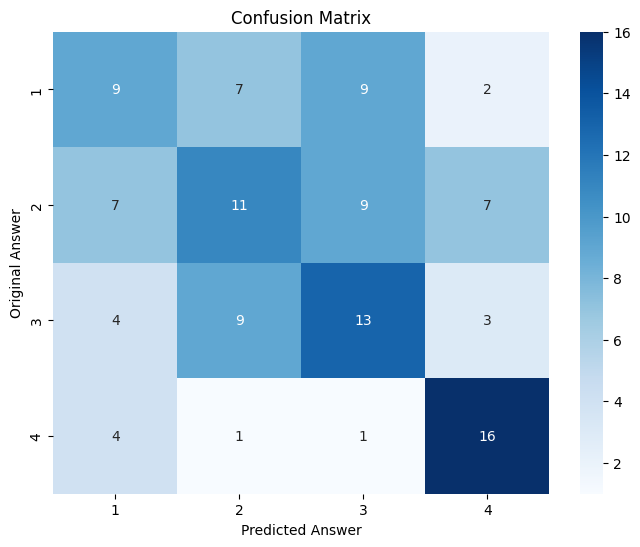

In [29]:
# Generate the classification report
report = classification_report(df_updated['Original Answer'], df_updated['llama_prediction'], zero_division=1)

# Create confusion matrix
conf_matrix = confusion_matrix(df_updated['Original Answer'], df_updated['llama_prediction'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['1', '2', '3', '4'], yticklabels=['1', '2', '3', '4'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Answer')
plt.ylabel('Original Answer')
plt.show()

In [31]:
print(report)

              precision    recall  f1-score   support

           1       0.38      0.33      0.35        27
           2       0.39      0.32      0.35        34
           3       0.41      0.45      0.43        29
           4       0.57      0.73      0.64        22

    accuracy                           0.44       112
   macro avg       0.44      0.46      0.44       112
weighted avg       0.43      0.44      0.43       112



In [32]:
# مقایسه پاسخ‌های صحیح و پیش‌بینی‌شده
df_updated['is_correct_llama'] = df_updated['Original Answer'] == df_updated['llama_prediction']

# محاسبه دقت کلی (درصد سوالات پاسخ داده شده به درستی)
accuracy = df_updated['is_correct_llama'].mean()
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 43.75%


In [34]:
# Function to display wrong predictions with RTL formatting for Passage, Question, and Options
from IPython.display import display, HTML

def display_wrong_prediction(row):
    html = f"""
    <div style='border: 2px solid red; padding: 10px; margin-bottom: 10px;'>
        <p><strong>Row {row.name + 1}:</strong></p>
        <p><strong>Passage:</strong> <span style='direction: rtl; text-align: right; display: block;'>{row['Passage']}</span></p>
        <p><strong>Question:</strong> <span style='direction: rtl; text-align: right; display: block;'>{row['Question']}</span></p>
        <p><strong>Original Answer:</strong> {row['Original Answer']}</p>
        <p><strong>Predicted Answer by LLama:</strong> {row['llama_prediction']}</p>
        <p><strong>Predicted Answer by Cohere:</strong> {row['cohere_prediction']}</p>
        <p><strong>Options:</strong> 
            <br><span style='direction: rtl; text-align: right; display: block;'>1: {row['Option 1']}</span>
            <br><span style='direction: rtl; text-align: right; display: block;'>2: {row['Option 2']}</span>
            <br><span style='direction: rtl; text-align: right; display: block;'>3: {row['Option 3']}</span>
            <br><span style='direction: rtl; text-align: right; display: block;'>4: {row['Option 4']}</span>
        </p>
    </div>
    """
    display(HTML(html))

# Display only the rows with wrong predictions
wrong_predictions_llama = df_updated[df_updated['Original Answer'] != df_updated['llama_prediction']]

# Apply the display function to all wrong predictions
for index, row in wrong_predictions_llama.iterrows():
    display_wrong_prediction(row)


# GPT 4o Prediction

Sure, I'll provide the predicted answers directly for each entry based on the passages and questions. Here are the answers for each item listed in your dataset:

1. **Index 7**: Option 3 - "10010"
2. **Index 10**: Option 2 - "ضرورت اجتناب از انتقاد"
3. **Index 15**: Option 1 - "دیوارهای ضخیم قلعه به درخواست Lord Hastings ساخته شده بود"
4. **Index 16**: Option 1 - "پنجره‌های بزرگ"
5. **Index 28**: Option 1 - "خدمات مشتریان"
6. **Index 43**: Option 4 - "آیا اصول اساسی کلیسا برآورده می‌شد"
7. **Index 55**: Option 4 - "استعداد"
8. **Index 62**: Option 1 - "چه مقدار از ماده ژنتیک تحت تأثیر قرار گرفته است"
9. **Index 63**: Option 2 - "به کوتاه کردن چمن‌ها کمک می‌کردند"
10. **Index 71**: Option 3 - "به مدت هزاران سال"
11. **Index 77**: Option 1 - "صدای ملایم‌تر"
12. **Index 80**: Option 3 - "برای تحمل وزن استفاده می‌شوند"
13. **Index 84**: Option 1 - "مشکلات گوارش و هضم"
14. **Index 98**: Option 1 - "قبل از اینکه دوباره بخوابید یک ساعت و نیم مطالعه کنید"
15. **Index 99**: Option 2 - "هدف کامل بیدار کردن خود نیست"
16. **Index 103**: Option 3 - "تیم‌های معمولی استقلال کمتری نسبت به تیم‌های مجازی دارند"
17. **Index 105**: Option 3 - "حفظ سوژه در یک مکان معین و مؤثر"
18. **Index 106**: Option 2 - "از فرمت‌های دوربین‌های دیجیتال اقتباس شده است"
19. **Index 108**: Option 2 - "اگر عناصر لنز کمتری می‌خواهید"
20. **Index 115**: Option 3 - "تمامی مناطق در شمال شرق افغانستان"
21. **Index 116**: Option 2 - "تمدن ایندوس - سرسوتی"
22. **Index 122**: Option 1 - "درمان اختلال اضطراب پس از سانحه با آرامبخش‌های مختلف"
23. **Index 134**: Option 4 - "انتصاب ولادیسلاو گومولکا"
24. **Index 135**: Option 3 - "اختلاف در پروسه‌ها"
25. **Index 137**: Option 3 - "همه عجایب هفتگانه"

These answers are derived directly based on context interpretation from the passages and questions provided. Let me know if you need further explanation for any specific item.

# GPT o1 prediction

Sure, here are my predictions for each question:

- **Question 7**: 3
- **Question 10**: 2
- **Question 15**: 1
- **Question 16**: 2
- **Question 28**: 3
- **Question 43**: 2
- **Question 55**: 2
- **Question 62**: 1
- **Question 63**: 3
- **Question 71**: 3
- **Question 77**: 2
- **Question 80**: 3
- **Question 84**: 1
- **Question 98**: 1
- **Question 99**: 4
- **Question 103**: 1
- **Question 105**: 3
- **Question 106**: 3
- **Question 108**: 4
- **Question 115**: 3
- **Question 116**: 3
- **Question 122**: 1
- **Question 134**: 4
- **Question 135**: 2
- **Question 137**: 3
- **Question 143**: 2
- **Question 161**: 1
- **Question 165**: 4
- **Question 175**: 2
- **Question 198**: 4
- **Question 203**: 1
- **Question 218**: 3
- **Question 222**: 1
- **Question 226**: 4
- **Question 242**: 1
- **Question 243**: 3
- **Question 247**: 2
- **Question 248**: 2
- **Question 252**: 2
- **Question 259**: 3
- **Question 266**: 1
- **Question 289**: 4
- **Question 292**: 1
- **Question 300**: 2
- **Question 303**: 1
- **Question 308**: 1
- **Question 311**: 3
- **Question 315**: 4
- **Question 317**: 2
- **Question 330**: 3
- **Question 352**: 2
- **Question 355**: 2
- **Question 356**: 4
- **Question 364**: 1
- **Question 371**: 2
- **Question 380**: 3
- **Question 392**: 2
- **Question 394**: 3
- **Question 400**: 1
- **Question 405**: 3
- **Question 406**: 1
- **Question 425**: 3
- **Question 428**: 4
- **Question 429**: 3
- **Question 430**: 2
- **Question 442**: 2
- **Question 447**: 2
- **Question 448**: 1
- **Question 451**: 1
- **Question 452**: 4
- **Question 453**: 3
- **Question 457**: 1
- **Question 471**: 2
- **Question 495**: 4
- **Question 505**: 3
- **Question 510**: 2
- **Question 514**: 2
- **Question 518**: 3
- **Question 524**: 2
- **Question 529**: 2
- **Question 534**: 4
- **Question 547**: 4
- **Question 559**: 4
- **Question 560**: 3
- **Question 579**: 4
- **Question 594**: 4
- **Question 595**: 3
- **Question 615**: 4
- **Question 620**: 2
- **Question 636**: 1
- **Question 640**: 4
- **Question 645**: 2
- **Question 652**: 2
- **Question 655**: 1
- **Question 659**: 2
- **Question 671**: 2
- **Question 675**: 3
- **Question 676**: 3
- **Question 678**: 3
- **Question 696**: 4
- **Question 698**: 3
- **Question 699**: 2
- **Question 717**: 3
- **Question 724**: 3
- **Question 726**: 2
- **Question 735**: 4
- **Question 740**: 3
- **Question 745**: 3
- **Question 753**: 1
- **Question 759**: 2
- **Question 772**: 2
- **Question 779**: 4